In [8]:
import os
import pandas as pd
import glob
import numpy as np
from tqdm import tqdm
import pandas as pd
import os
import glob  
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pyranges as pr
from kipoiseq import Interval
import pyfaidx
import kipoiseq
from collections import Counter
import gseapy as gp
import seaborn as sns
from memelite import tomtom, fimo
from memelite.io import read_meme
from memelite.utils import one_hot_encode
import gseapy as gp
import matplotlib as mpl # 
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
# disablke warnings
import warnings
warnings.filterwarnings("ignore")
# %matplotlib inline

In [9]:
def plot_manhattan(ax, df, title, threshold=5e-8, ymax=None, sign='LOG10P', colors = ['skyblue', 'navy']):
    # colors = ['skyblue', 'navy'] 
    # Work on a copy so the original DataFrame is not modified
    df_plot = df.copy()
    df_plot['BP_cum'] = 0
    chrom_order = sorted(df_plot['CHROM'].unique(), key=lambda x: int(x))
    cum_bp = 0
    ticks = []
    labels = []
    for chrom in chrom_order:
        mask = df_plot['CHROM'] == chrom
        # Compute cumulative base pair positions
        df_plot.loc[mask, 'BP_cum'] = df_plot.loc[mask, 'GENPOS'] + cum_bp
        ticks.append(df_plot.loc[mask, 'BP_cum'].median())
        labels.append(chrom)
        cum_bp += df_plot.loc[mask, 'GENPOS'].max()
    
    # Plot points for each chromosome using alternating colors
    for i, chrom in enumerate(chrom_order):
        chrom_data = df_plot[df_plot['CHROM'] == chrom]
        # chrom_data_high_pip = chrom_data[chrom_data['PIP'] > 0.8]
        ax.scatter(chrom_data['BP_cum'], chrom_data[sign],
                   color=colors[i % len(colors)],
                   s=5, label=f'Chr {chrom}')
        # ax.scatter(chrom_data_high_pip['BP_cum'], chrom_data_high_pip[sign],
        #            color='green',
        #            s=5, label=f'Chr {chrom}')
    
    # ax.set_xlabel('Chromosome')
    ax.set_ylabel(sign)
    # ax.set_title(title)
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=45)
    # Draw a significance threshold line (e.g., p-value = 5e-8)
    if threshold is not None:
        ax.axhline(threshold, color='red', linestyle='dashed', lw=1)
    ax.margins(x=0.01, y=0.02)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    # Remove unwanted spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    # if ymax is not None:
    #     plt.ylim(0, ymax)
# VAR2TFBS pipeline
def motif_scan_rareVars(fn='K562', fp_ext=0, seq_ext=30):
    motifs = read_meme("../FOODIE_20250407/JASPAR_MEME/JASPAR2024_CORE_vertebrates_non-redundant_pfms_meme.txt")
    # motifs = read_meme("./JASPAR_MEME/consensus_pwms.meme")
     # Reference alleles
    hits = fimo(motifs, './fasta_for_fimo_rarevar/{}_fpExt{}bp_raresig_ref_seqExt{}bp.fa'.format(cell, fp_ext, seq_ext), threshold=0.0001)  
    his_df = []
    for h in hits:
        if h.empty:
            continue
        his_df.append(h)
    ref_hits_df = pd.concat(his_df, ignore_index=True)
    ref_hits_df['motif_id'] = ref_hits_df['motif_name'].str.split(' ').str[0] + ref_hits_df['strand']
    ref_hits_df['motif_name'] = ref_hits_df['motif_name'].str.split(' ').str[1] + ref_hits_df['strand']
    ref_hits_df['motif_info'] = ref_hits_df['motif_id'] + '-' + ref_hits_df['motif_name'] + '_' + ref_hits_df['start'].astype(str) + '_' + ref_hits_df['end'].astype(str)
    ref_hits_df['var-motif'] = ref_hits_df['sequence_name'] + '-' + ref_hits_df['motif_info']
    ref_hits_df['foodie_id'] = ref_hits_df['sequence_name'].str.split('_').str[-1]
    ref_hits_df['SNP'] = ref_hits_df['sequence_name'].str.split('_').str[0]
    ref_hits_df['pos_var'] = ref_hits_df['SNP'].str.split(':').str[2].astype(int) - 1
    ref_hits_df['chrom_fp'] = ref_hits_df['foodie_id'].str.split(':').str[0]
    ref_hits_df['start_fp'] = ref_hits_df['foodie_id'].str.split(':').str[-1].str.split('-').str[0].astype(int)
    ref_hits_df['end_fp'] = ref_hits_df['foodie_id'].str.split(':').str[-1].str.split('-').str[1].astype(int)   
    ref_hits_df['pos_var_in_fp'] = ref_hits_df['pos_var'] - ref_hits_df['start_fp']
    ref_hits_df['start_motif'] = ref_hits_df['start'] - seq_ext + ref_hits_df['start_fp']
    ref_hits_df['end_motif'] = ref_hits_df['end'] - seq_ext + ref_hits_df['start_fp']
    ref_hits_df['var_in_motif'] = (ref_hits_df['pos_var'] >= ref_hits_df['start_motif']) & (ref_hits_df['pos_var'] < ref_hits_df['end_motif'])
    ref_hits_df = ref_hits_df[ref_hits_df['var_in_motif']].reset_index(drop=True)
    # alternative alleles
    hits = fimo(motifs, './fasta_for_fimo_rarevar/{}_fpExt{}bp_raresig_alt_seqExt{}bp.fa'.format(cell, fp_ext, seq_ext), threshold=0.0001)  
    his_df = []
    for h in hits:
        if h.empty:
            continue
        his_df.append(h)
    alt_hits_df = pd.concat(his_df, ignore_index=True)
    alt_hits_df['motif_id'] = alt_hits_df['motif_name'].str.split(' ').str[0] + alt_hits_df['strand']
    alt_hits_df['motif_name'] = alt_hits_df['motif_name'].str.split(' ').str[1] + alt_hits_df['strand']
    alt_hits_df['motif_info'] = alt_hits_df['motif_id'] + '-' + alt_hits_df['motif_name'] + '_' + alt_hits_df['start'].astype(str) + '_' + alt_hits_df['end'].astype(str)
    alt_hits_df['var-motif'] = alt_hits_df['sequence_name'] + '-' + alt_hits_df['motif_info' ] 
    alt_hits_df['foodie_id'] = alt_hits_df['sequence_name'].str.split('_').str[-1]
    alt_hits_df['SNP'] = alt_hits_df['sequence_name'].str.split('_').str[0]
    alt_hits_df['pos_var'] = alt_hits_df['SNP'].str.split(':').str[2].astype(int) - 1
    alt_hits_df['chrom_fp'] = alt_hits_df['foodie_id'].str.split(':').str[0]
    alt_hits_df['start_fp'] = alt_hits_df['foodie_id'].str.split(':').str[-1].str.split('-').str[0].astype(int)
    alt_hits_df['end_fp'] = alt_hits_df['foodie_id'].str.split(':').str[-1].str.split('-').str[1].astype(int)   
    alt_hits_df['pos_var_in_fp'] = ref_hits_df['pos_var'] - ref_hits_df['start_fp']
    alt_hits_df['start_motif'] = alt_hits_df['start'] - seq_ext + alt_hits_df['start_fp']
    alt_hits_df['end_motif'] = alt_hits_df['end'] - seq_ext + alt_hits_df['start_fp']
    alt_hits_df['var_in_motif'] = (alt_hits_df['pos_var'] >= alt_hits_df['start_motif']) & (alt_hits_df['pos_var'] < alt_hits_df['end_motif'])
    alt_hits_df = alt_hits_df[alt_hits_df['var_in_motif']].reset_index(drop=True)
    ref_alt_hits_df = ref_hits_df.merge(alt_hits_df, suffixes=['_ref', '_alt'], on=['var-motif'], how='outer').reset_index(drop=True)
    ref_alt_hits_df['sequence_name'] = ref_alt_hits_df['sequence_name_ref'].fillna(ref_alt_hits_df['sequence_name_alt'])
    return ref_alt_hits_df, ref_hits_df, alt_hits_df

# sequence extractor from hg38
class FastaStringExtractor:
    def __init__(self, fasta_file):
        self.fasta = pyfaidx.Fasta(fasta_file)
        self._chromosome_sizes = {k: len(v) for k, v in self.fasta.items()}

    def extract(self, interval: Interval, **kwargs) -> str:
        # Truncate interval if it extends beyond the chromosome lengths.
        chromosome_length = self._chromosome_sizes[interval.chrom]
        trimmed_interval = Interval(interval.chrom,
                                    max(interval.start, 0),
                                    min(interval.end, chromosome_length),
                                    )
        # pyfaidx wants a 1-based interval
        sequence = str(self.fasta.get_seq(trimmed_interval.chrom,
                                          trimmed_interval.start + 1,
                                          trimmed_interval.stop).seq).upper()
        # Fill truncated values with N's
        pad_upstream = 'N' * max(-interval.start, 0)
        pad_downstream = 'N' * max(interval.end - chromosome_length, 0)
        return pad_upstream + sequence + pad_downstream
    def close(self):
        return self.fasta.close()
        
seq_extractor = FastaStringExtractor('/cpl/home/linjc/reference_data/hg38.fa')

In [10]:
K562_foodie = pr.read_bed('../FOODIE_20250407/FOODIE_merged_footprints/K562.merged.hg38.bed')[['Chromosome', 'Start', 'End', 'Name']]
K562_prot_coding_genes_dedup = pd.read_csv('./expression_data/K562_prot_coding_genes_dedup.tsv', sep='\t', index_col=0)
GM12878_prot_coding_genes_dedup = pd.read_csv('./expression_data/GM12878_prot_coding_genes_dedup.tsv', sep='\t', index_col=0)
gene_expr = {'K562': K562_prot_coding_genes_dedup, 'GM12878': GM12878_prot_coding_genes_dedup}
TF_K562_GM12878_merged = pd.read_csv('./expression_data/TF_K562_GM12878_expression.csv') # TF expression file
loo_all_traits_df = pd.read_csv('./K562.leave_one_out.all_traits.20251120.csv') # leave-one-out-analysis
loo_all_traits_short = loo_all_traits_df.set_index(['ID_rare', 'trait'])[['p_regenie', 'LOG10P', 'BETA', 'SE']] # leave-one-out-analysis

In [11]:
loo_all_traits_df['foodie'].nunique()

24

In [12]:
192 + 14

206

In [13]:
K562_prot_coding_genes_dedup.loc['HBZ']

target_id          ENST00000252951.2|ENSG00000130656.4|OTTHUMG000...
length                                                           755
eff_length                                                   533.761
est_counts                                                   4132.85
tpm                                                          55.3521
gene_id                                            ENSG00000130656.4
transcript_name                                              HBZ-201
Name: HBZ, dtype: object

In [14]:
# significant pvalues after bonferroni correction
K562_foodie = pr.read_bed('../FOODIE_20250407/FOODIE_merged_footprints/K562.merged.hg38.bed')
print('Rare burden test alpha', 0.05/len(K562_foodie), -np.log10(0.05/len(K562_foodie)), len(K562_foodie))

Rare burden test alpha 2.652745060588697e-07 6.576304485449121 188484


In [15]:
# filtered rare variants with low carriers
K562_rareVars = pd.read_csv('../FOODIE_20250407/fpGWAS_varBridge_results/K562_rareVar_sig_annot.csv')
K562_rareVars['Start_foodie'] = K562_rareVars['Name_foodie'].str.split(':').str[1].str.split('-').str[0].astype(int)
K562_rareVars['End_foodie'] = K562_rareVars['Name_foodie'].str.split(':').str[1].str.split('-').str[1].astype(int)
K562_erythroid_rarevars = K562_rareVars[K562_rareVars['Type']=='Erythroid'].reset_index(drop=True)
K562_erythroid_rarevars_dedup = K562_erythroid_rarevars[['SNP', 'Name_foodie']].drop_duplicates().reset_index(drop=True)
print(len(K562_erythroid_rarevars))

# GM12878_rareVars = pd.read_csv('../FOODIE_20250407/fpGWAS_varBridge_results/GM12878_rareVar_sig_annot.csv')
carray_df = pd.read_excel('./K562_foodie_carray-20251117.xlsx', sheet_name='rare_site_carray')
var_carriers = carray_df.groupby('site')['IID'].count().reset_index().rename(columns={'IID':'#carriers'})

for add_feats in [['p_regenie', 'LOG10P', 'BETA', 'SE']]:
    K562_erythroid_rarevars[add_feats[0]+'_loo'] = np.nan
    K562_erythroid_rarevars[add_feats[1]+'_loo'] = np.nan
    K562_erythroid_rarevars[add_feats[2]+'_loo'] = np.nan
    K562_erythroid_rarevars[add_feats[3]+'_loo'] = np.nan
for idx, row in K562_erythroid_rarevars.iterrows():
    snp = row['SNP']
    trait = row['Trait']
    # foodie_name = row['Name_foodie']
    for add_feats in [['p_regenie', 'LOG10P', 'BETA', 'SE']]:
        try:
            loo_all_traits_short.loc[(snp, trait), add_feats[0]]
        except KeyError:
            continue
        K562_erythroid_rarevars.at[idx, add_feats[0]+'_loo'] = loo_all_traits_short.loc[(snp, trait), add_feats[0]]
        K562_erythroid_rarevars.at[idx, add_feats[1]+'_loo'] = loo_all_traits_short.loc[(snp, trait), add_feats[1]]
        K562_erythroid_rarevars.at[idx, add_feats[2]+'_loo'] = loo_all_traits_short.loc[(snp, trait), add_feats[2]]
        K562_erythroid_rarevars.at[idx, add_feats[3]+'_loo'] = loo_all_traits_short.loc[(snp, trait), add_feats[3]]
K562_erythroid_rarevars['delta_LOG10P'] = K562_erythroid_rarevars['LOG10P_loo'] - K562_erythroid_rarevars['LOG10P']

carray_df = pd.read_excel('./K562_foodie_carray-20251117.xlsx', sheet_name='rare_site_carray')
carray_sum = carray_df.groupby('site')[['HC', 'HLDRC', 'HLSRP', 'HP',
       'IRF', 'MCH', 'MCHC', 'MCV', 'MRV', 'MSCV', 'RBC', 'RBCDW', 'RC', 'RP']].sum()
for idx, row in K562_erythroid_rarevars.iterrows():
    snp = row['SNP']
    trait = row['Trait']
    foodie_name = row['Name_foodie']
    carrier_count = carray_sum.loc[snp, trait]
    K562_erythroid_rarevars.at[idx, 'Carrier_count'] = carrier_count
K562_erythroid_rarefp_carrier_count = K562_erythroid_rarevars.groupby('Name_foodie')['Carrier_count'].max().reset_index().rename(columns={'Carrier_count': 'Max_carrier_count'})
fp_with_enough_carriers = list(K562_erythroid_rarefp_carrier_count[K562_erythroid_rarefp_carrier_count['Max_carrier_count'] > 30]['Name_foodie'])
fp_without_enough_carriers = list(K562_erythroid_rarefp_carrier_count[K562_erythroid_rarefp_carrier_count['Max_carrier_count'] <= 30]['Name_foodie'])
K562_erythroid_rarevars = K562_erythroid_rarevars.set_index('footprint_type').loc[fp_with_enough_carriers].reset_index()
K562_erythroid_rarevars = K562_erythroid_rarevars.merge(var_carriers.rename(columns={'#carriers':'Carrier_count_total'}), left_on='SNP', right_on='site')
K562_erythroid_rarevars['Carrier_count'] = K562_erythroid_rarevars['Carrier_count'].astype(int)
print(len(K562_erythroid_rarevars), 'variants after filtering')

1056
1018 variants after filtering


In [16]:
K562_erythroid_rarevars['Name_foodie'].nunique()

21

In [17]:
K562_erythroid_rarevars_dedup

,SNP,Name_foodie
0,DRAGEN:chr16:234777:GC:G,chr16:234776-234784
1,DRAGEN:chr16:234777:G:A,chr16:234776-234784
2,DRAGEN:chr16:234777:G:T,chr16:234776-234784
3,DRAGEN:chr16:234778:C:G,chr16:234776-234784
4,DRAGEN:chr16:234778:C:A,chr16:234776-234784
...,...,...
309,DRAGEN:chr9:112487728:A:G,chr9:112487722-112487736
310,DRAGEN:chr9:112487729:T:A,chr9:112487722-112487736
311,DRAGEN:chr9:112487731:TGAG:T,chr9:112487722-112487736
312,DRAGEN:chr9:112487731:T:G,chr9:112487722-112487736


In [19]:
# K562_erythroid_rarevars_dedup['Name_foodie'].nunique(), K562_erythroid_rarevars['Name_foodie'].nunique()

In [18]:
K562_erythroid_rarevars

,footprint_type,CHROM,GENPOS,Name_foodie,ALLELE0,ALLELE1,A1FREQ,INFO,N,TEST,...,ref_sequence_30,alt_sequence_30,p_regenie_loo,LOG10P_loo,BETA_loo,SE_loo,delta_LOG10P,Carrier_count,site,Carrier_count_total
0,chr11:3379254-3379274,11,3379264,chr11:3379254-3379274,A,True,0.000218,1,469409,ADD,...,TCCCCGCCCCTACTCCTCTGATTGGATAGGGCATCACGCCCCGCCC...,TCCCCGCCCCTACTCCTCTGATTGGATAGGGAATCACGCCCCGCCC...,2.525399e-07,6.59767,0.325451,0.063123,-0.21094,6,DRAGEN:chr11:3379255:G:A,6
1,chr11:3379254-3379274,11,3379264,chr11:3379254-3379274,A,True,0.000218,1,469409,ADD,...,TCCCCGCCCCTACTCCTCTGATTGGATAGGGCATCACGCCCCGCCC...,TCCCCGCCCCTACTCCTCTGATTGGATAGGGCATCACGCCCCGCCC...,3.052460e-07,6.51535,0.319110,0.062324,-0.29326,1,DRAGEN:chr11:3379259:C:A,1
2,chr11:3379254-3379274,11,3379264,chr11:3379254-3379274,A,True,0.000218,1,469409,ADD,...,TCCCCGCCCCTACTCCTCTGATTGGATAGGGCATCACGCCCCGCCC...,TCCCCGCCCCTACTCCTCTGATTGGATAGGGCATCAACGCCCGCCC...,1.733804e-07,6.76100,0.325726,0.062330,-0.04761,1,DRAGEN:chr11:3379260:A:ACGCCC,1
3,chr11:3379254-3379274,11,3379264,chr11:3379254-3379274,A,True,0.000218,1,469409,ADD,...,TCCCCGCCCCTACTCCTCTGATTGGATAGGGCATCACGCCCCGCCC...,TCCCCGCCCCTACTCCTCTGATTGGATAGGGCATCAGGCCCCGCCC...,1.800653e-07,6.74457,0.325259,0.062324,-0.06404,1,DRAGEN:chr11:3379260:A:G,1
4,chr11:3379254-3379274,11,3379264,chr11:3379254-3379274,A,True,0.000218,1,469409,ADD,...,TCCCCGCCCCTACTCCTCTGATTGGATAGGGCATCACGCCCCGCCC...,TCCCCGCCCCTACTCCTCTGATTGGATAGGGCATCACTCCCCGCCC...,1.529361e-07,6.81549,0.327172,0.062330,0.00688,1,DRAGEN:chr11:3379261:C:T,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1013,chr8:41792600-41792630,8,41792615,chr8:41792600-41792630,A,True,0.001356,1,461496,ADD,...,TGACTCAAAGATGAGTCAGATGGAGCTGTTGCCCGCCTCCCGCCCG...,TGACTCAAAGATGAGTCAGATGGAGCTGTTGCCCGCCTCCCGCCCG...,1.903005e-08,7.72056,0.149713,0.026637,0.32417,39,DRAGEN:chr8:41792616:G:A,41
1014,chr8:41792600-41792630,8,41792615,chr8:41792600-41792630,A,True,0.001356,1,461496,ADD,...,TGACTCAAAGATGAGTCAGATGGAGCTGTTGCCCGCCTCCCGCCCG...,TGACTCAAAGATGAGTCAGATGGAGCTGTTGCCCGCCTCCCGCCCG...,5.256540e-08,7.27930,0.143732,0.026410,-0.11709,18,DRAGEN:chr8:41792624:C:T,18
1015,chr8:41792600-41792630,8,41792615,chr8:41792600-41792630,A,True,0.001356,1,461496,ADD,...,TGACTCAAAGATGAGTCAGATGGAGCTGTTGCCCGCCTCCCGCCCG...,TGACTCAAAGATGAGTCAGATGGAGCTGTTGCCCGCCTCCCGCCCG...,6.244677e-08,7.20449,0.142402,0.026314,-0.19190,9,DRAGEN:chr8:41792625:G:A,9
1016,chr8:41792600-41792630,8,41792615,chr8:41792600-41792630,A,True,0.001356,1,461496,ADD,...,TGACTCAAAGATGAGTCAGATGGAGCTGTTGCCCGCCTCCCGCCCG...,TGACTCAAAGATGAGTCAGATGGAGCTGTTGCCCGCCTCCCGCCCG...,3.707490e-08,7.43092,0.144607,0.026272,0.03453,5,DRAGEN:chr8:41792627:G:A,6


In [19]:
# K562_erythroid_rarevars_dedup

In [20]:
# extract the fasta for REF and ALT alleles
print('extracting fasta sequences for REF and ALT alleles...')
rareVar_cell = {'K562': K562_rareVars}
ext_bp = 30
fp_ext = 0
for cell in ['K562']:
    print('processing {}...'.format(cell))
    sig_vars_dedup = rareVar_cell[cell].drop_duplicates(subset='SNP').reset_index(drop=True)
    for idx, row in tqdm(sig_vars_dedup.iterrows(), total=sig_vars_dedup.shape[0]):
        chrom = row['Chromosome']
        ref_var = row['REF']
        alt_var = row['ALT']
        if len(ref_var) > 1:
            start_fp = row['Start_foodie'] - ext_bp - len(ref_var)
            end_fp = row['End_foodie'] + ext_bp + len(ref_var)
        else:
            start_fp = row['Start_foodie'] - ext_bp
            end_fp = row['End_foodie'] + ext_bp
        var_pos = row['POS']
        var_fp_name = row['SNP'] + '_' +  row['Name_foodie']
        # ref_seq = get_fasta_seq(chrom, var_pos, ref_var, ref_seq_file)
        var_pos_in_fp = var_pos - start_fp - 1 
        ref_seq = seq_extractor.extract(Interval(chrom, start_fp, end_fp))
        alt_seq = ref_seq[:var_pos_in_fp] + alt_var + ref_seq[var_pos_in_fp + len(ref_var):]
        sig_vars_dedup.at[idx, 'Ref_seq'] = ref_seq
        sig_vars_dedup.at[idx, 'Alt_seq'] = alt_seq

    with open('./fasta_for_fimo_rarevar/{}_fpExt{}bp_raresig_ref_seqExt{}bp.fa'.format(cell, fp_ext, ext_bp), 'w') as ref_fa:
        for idx, row in sig_vars_dedup.iterrows():
            ref_fa.write('>{}\n{}\n'.format(row['SNP']+'_'+row['Name_foodie'], row['Ref_seq']))
    with open('./fasta_for_fimo_rarevar/{}_fpExt{}bp_raresig_alt_seqExt{}bp.fa'.format(cell, fp_ext, ext_bp), 'w') as alt_fa:
        for idx, row in sig_vars_dedup.iterrows():
            alt_fa.write('>{}\n{}\n'.format(row['SNP']+'_'+row['Name_foodie'], row['Alt_seq']))

extracting fasta sequences for REF and ALT alleles...
processing K562...


  0%|          | 0/840 [00:00<?, ?it/s]

100%|██████████| 840/840 [00:00<00:00, 2293.13it/s]


In [21]:
# obtain the driver rare variants by leave-one-out-analysis
K562_erythroid_rarevars_valid = K562_erythroid_rarevars[K562_erythroid_rarevars['p_regenie_loo'] > 0.05/len(K562_foodie)].reset_index(drop=True)
K562_erythroid_rarevars_valid = K562_erythroid_rarevars_valid.sort_values(by=['Trait', 'Name_foodie', 'LOG10P_loo' ], ascending=True).drop_duplicates(subset=['Trait', 'Name_foodie'], keep='first').reset_index(drop=True)
K562_erythroid_rarevars_valid_dedup = K562_erythroid_rarevars_valid[['SNP', 'Name_foodie']].drop_duplicates().reset_index(drop=True)
K562_erythroid_rarevars_valid_dedup.shape

(21, 2)

In [23]:
K562_erythroid_rarevars_valid[K562_erythroid_rarevars_valid['footprint_type'] == 'chr16:145010-145040'][['Trait', 'site', 'p_regenie_loo', 'LOG10P_loo']]

,Trait,site,p_regenie_loo,LOG10P_loo
16,MCH,DRAGEN:chr16:145021:C:T,0.137316,0.862280
29,MCHC,DRAGEN:chr16:145021:C:T,0.774597,0.110924
37,MCV,DRAGEN:chr16:145021:C:T,0.056125,1.250840
54,RBC,DRAGEN:chr16:145021:C:T,0.163757,0.785799


In [25]:
K562_erythroid_rarevars_valid_dedup.sort_values(by=['Name_foodie']).shape

(21, 2)

In [26]:
# K562_erythroid_rarevars['Name_foodie'].nunique(), K562_erythroid_rarevars_valid_dedup.shape

In [27]:
tt = K562_erythroid_rarevars_valid.sort_values(by=['Trait', 'Name_foodie', 'site',  'LOG10P_loo'], ascending=False)
tt.set_index(['Trait', 'Name_foodie']).loc[[('MCH', 'chr16:145010-145040'), ('MCHC', 'chr16:145010-145040')]][['site', 'LOG10P_loo']]

,,site,LOG10P_loo
Trait,Name_foodie,,
MCH,chr16:145010-145040,DRAGEN:chr16:145021:C:T,0.862280
MCHC,chr16:145010-145040,DRAGEN:chr16:145021:C:T,0.110924


In [99]:
tt[tt['Name_foodie'] == 'chr16:145010-145040'][['Trait', 'site', 'p_regenie_loo', 'LOG10P_loo']]

,Trait,site,p_regenie_loo,LOG10P_loo
54,RBC,DRAGEN:chr16:145021:C:T,0.163757,0.785799
37,MCV,DRAGEN:chr16:145021:C:T,0.056125,1.250840
29,MCHC,DRAGEN:chr16:145021:C:T,0.774597,0.110924
16,MCH,DRAGEN:chr16:145021:C:T,0.137316,0.862280


In [100]:
tt.set_index(['Trait', 'Name_foodie']).loc[[('MCH', 'chr16:145010-145040')]]

,,footprint_type,CHROM,GENPOS,ALLELE0,ALLELE1,A1FREQ,INFO,N,TEST,BETA,...,ref_sequence_30,alt_sequence_30,p_regenie_loo,LOG10P_loo,BETA_loo,SE_loo,delta_LOG10P,Carrier_count,site,Carrier_count_total
Trait,Name_foodie,,,,,,,,,,,,,,,,,,,,,
MCH,chr16:145010-145040,chr16:145010-145040,16,145025,A,True,0.000811,1,469409,ADD,-0.231618,...,GCCTCAGATGGAAACGCCCTCCTCACGGAGGCATCTCTCCCGGCCT...,GCCTCAGATGGAAACGCCCTCCTCACGGAGGCATCTCTCCCTGCCT...,0.137316,0.86228,0.164585,0.110767,-10.30382,697,DRAGEN:chr16:145021:C:T,741


In [28]:
K562_erythroid_rarevars_valid[K562_erythroid_rarevars_valid['Name_foodie'] == 'chr7:134316621-134316638'][['site','Trait', 'LOG10P_loo', 'Name_foodie']]

,site,Trait,LOG10P_loo,Name_foodie
28,DRAGEN:chr7:134316632:C:T,MCH,5.33715,chr7:134316621-134316638
36,DRAGEN:chr7:134316632:C:T,MCHC,5.67841,chr7:134316621-134316638


In [102]:
# K562_erythroid_rarevars_valid

In [103]:
# tt = K562_erythroid_rarevars[(K562_erythroid_rarevars['footprint_type'] == 'chr16:145010-145040')&(K562_erythroid_rarevars['Trait'] == 'MCV')].reset_index()
# tt[tt['p_regenie_loo']> 0.05/len(K562_foodie)]

In [104]:
# tt = K562_erythroid_rarevars[(K562_erythroid_rarevars['footprint_type'] == 'chr16:145010-145040')].reset_index()
# tt[tt['p_regenie_loo']> 0.05/len(K562_foodie)][['Trait', 'site', 'p_regenie_loo', 'LOG10P_loo', 'Carrier_count']]

In [26]:
# VAR2TFBS workflow for identifying TFBSs that are affected by rare variants
print('Running VAR2TFBS...')
cell = 'K562'
seq_ext = 30
# fp_ext = 10
ref_alt_rareVar, ref_hits_rareVar, alt_hits_rareVar = motif_scan_rareVars('K562', fp_ext=0, seq_ext=seq_ext)
for idx, row in tqdm(ref_alt_rareVar.iterrows(), total=ref_alt_rareVar.shape[0]):
    var_id, fp_id = row['sequence_name'].split('_')
    var_id = ':'.join(var_id.replace('DRAGEN:', '').split(':')[:-1]) + '>' + var_id.replace('DRAGEN:', '').split(':')[-1]
    ref_alt_rareVar.at[idx, 'sequence_name'] = ref_alt_rareVar.at[idx, 'sequence_name'].split('_')[0]
    ref_alt_rareVar.at[idx, 'variant_id'] = var_id
    ref_alt_rareVar.at[idx, 'foodie_id'] = fp_id
ref_alt_rareVar['p-value_ref'] = ref_alt_rareVar['p-value_ref'].fillna(1)
ref_alt_rareVar['p-value_alt'] = ref_alt_rareVar['p-value_alt'].fillna(1)
for idx, row in tqdm(ref_alt_rareVar.iterrows(),  total=ref_alt_rareVar.shape[0]):
    if row['p-value_ref'] != 1 and row['p-value_alt'] != 1:
        if row['p-value_ref'] > row['p-value_alt']:
            ref_alt_rareVar.at[idx, 'TF_change'] = 'Increase'
        elif row['p-value_ref'] < row['p-value_alt']:
            ref_alt_rareVar.at[idx, 'TF_change'] = 'Decrease'
        else:
            ref_alt_rareVar.at[idx, 'TF_change'] = 'Unchange'
    elif row['p-value_ref'] == 1 and row['p-value_alt'] != 1:
        ref_alt_rareVar.at[idx, 'TF_change'] = 'Create'
    elif row['p-value_ref'] != 1 and row['p-value_alt'] == 1:
        ref_alt_rareVar.at[idx, 'TF_change'] = 'Disrupt'
    else:
        ref_alt_rareVar.at[idx, 'TF_change'] = 'NoTFBS'
K562_ref_alt_rareVar_change_df = ref_alt_rareVar# [ref_alt_rareVar['TF_change'] != 'Unchange'].reset_index(drop=True)
K562_ref_alt_rareVar_change_df['start_var'] = K562_ref_alt_rareVar_change_df['start_ref'].fillna(K562_ref_alt_rareVar_change_df['start_alt'])
K562_ref_alt_rareVar_change_df['end_var'] = K562_ref_alt_rareVar_change_df['end_ref'].fillna(K562_ref_alt_rareVar_change_df['end_alt'])
K562_ref_alt_rareVar_change_df['start_var'] = K562_ref_alt_rareVar_change_df['start_var']  - seq_ext
K562_ref_alt_rareVar_change_df['end_var'] = K562_ref_alt_rareVar_change_df['end_var']  - seq_ext
K562_ref_alt_rareVar_change_df['motif_name'] = K562_ref_alt_rareVar_change_df['motif_name_ref'].fillna(K562_ref_alt_rareVar_change_df['motif_name_alt'])
K562_ref_alt_rareVar_change_df['motif_info2'] = K562_ref_alt_rareVar_change_df['motif_name'] + '|' +  K562_ref_alt_rareVar_change_df['start_var'].astype(str) + '_' + K562_ref_alt_rareVar_change_df['end_var'].astype(str) + '|' + K562_ref_alt_rareVar_change_df['foodie_id']
K562_ref_alt_rareVar_change_df['TF'] = K562_ref_alt_rareVar_change_df['motif_name'].str[:-1].str.upper()
K562_ref_alt_rareVar_change_df.to_csv('./var_effect_on_tfbs/{}_blood_rareVar_change_tfbs.csv'.format(cell), index=False)
K562_ref_alt_rareVar_change_df['cell'] = cell
K562_ref_alt_rareVar_change_df['rsID'] = K562_ref_alt_rareVar_change_df['SNP_ref'].fillna(K562_ref_alt_rareVar_change_df['SNP_alt'])
K562_ref_alt_rareVar_change_df['TF'] = K562_ref_alt_rareVar_change_df['motif_name_ref'].fillna(K562_ref_alt_rareVar_change_df['motif_name_alt']).str[:-1].str.upper()

var_tfbs_alt_ref_all = []
for rsid in tqdm(K562_ref_alt_rareVar_change_df['rsID'].unique()):
    var_tfbs = K562_ref_alt_rareVar_change_df[K562_ref_alt_rareVar_change_df['rsID'] == rsid].reset_index(drop=True)
    foodie_id = var_tfbs.at[0, 'foodie_id']
    var_tfbs_ref = var_tfbs[['TF', 'motif_name_ref', 'motif_id_ref', 'p-value_ref', 'start_ref', 'end_ref']].reset_index(drop=True).dropna()
    var_tfbs_ref = var_tfbs_ref.sort_values(by=['TF', 'p-value_ref']).drop_duplicates(subset=['TF'], keep='first').reset_index(drop=True)
    var_tfbs_alt = var_tfbs[['TF', 'motif_name_alt', 'motif_id_alt', 'p-value_alt', 'start_alt', 'end_alt']].reset_index(drop=True).dropna()
    var_tfbs_alt = var_tfbs_alt.sort_values(by=['TF', 'p-value_alt']).drop_duplicates(subset=['TF'], keep='first').reset_index(drop=True)
    var_tfbs_alt_ref = var_tfbs_ref.merge(var_tfbs_alt, on='TF', how='outer').reset_index(drop=True)
    var_tfbs_alt_ref['rsID'] = rsid
    var_tfbs_alt_ref['foodie_id'] = foodie_id
    var_tfbs_alt_ref_all.append(var_tfbs_alt_ref)

var_tfbs_alt_ref_all = pd.concat(var_tfbs_alt_ref_all).reset_index(drop=True)
var_tfbs_alt_ref_all['p-value_ref'] = var_tfbs_alt_ref_all['p-value_ref'].fillna(1)
var_tfbs_alt_ref_all['p-value_alt'] = var_tfbs_alt_ref_all['p-value_alt'].fillna(1)
for idx, row in tqdm(var_tfbs_alt_ref_all.iterrows(),  total=var_tfbs_alt_ref_all.shape[0]):
    if row['p-value_ref'] != 1 and row['p-value_alt'] != 1:
        if row['p-value_ref'] > row['p-value_alt']:
            var_tfbs_alt_ref_all.at[idx, 'TF_change'] = 'Increase'
        elif row['p-value_ref'] < row['p-value_alt']:
            var_tfbs_alt_ref_all.at[idx, 'TF_change'] = 'Decrease'
        else:
            var_tfbs_alt_ref_all.at[idx, 'TF_change'] = 'Unchange'
    elif row['p-value_ref'] == 1 and row['p-value_alt'] != 1:
        var_tfbs_alt_ref_all.at[idx, 'TF_change'] = 'Create'
    elif row['p-value_ref'] != 1 and row['p-value_alt'] == 1:
        var_tfbs_alt_ref_all.at[idx, 'TF_change'] = 'Disrupt'
    else:
        var_tfbs_alt_ref_all.at[idx, 'TF_change'] = 'NoTFBS'
var_tfbs_alt_ref_all = var_tfbs_alt_ref_all.merge(TF_K562_GM12878_merged[['TF', '{}_rna_tpm'.format(cell)]], on='TF', how='left').reset_index(drop=True).rename(columns={'{}_rna_tpm'.format(cell):'TF_{}_rna_tpm'.format(cell)})

Running VAR2TFBS...


100%|██████████| 3501/3501 [00:00<00:00, 16502.75it/s]


In [27]:
print('processing fp2gene with ABC-FP-Max')
K562_atac = pr.read_bed('/cpl/home/linjc/tools/ABC_footprinting/FOODIE_ATAC_50bp_nopro_results/K562_FOODIE_ATAC//Neighborhoods/EnhancerList.bed')
K562_foodie = pr.read_bed('../FOODIE_20250407/FOODIE_merged_footprints/K562.merged.hg38.bed')
K562_foodie_atac = K562_foodie.join(K562_atac, suffix='_ATAC').df.reset_index()
K562_foodie_atac['Length_ATAC'] = K562_foodie_atac['End_ATAC'] - K562_foodie_atac['Start_ATAC']
K562_foodie_atac['Length_foodie'] = K562_foodie_atac['End'] - K562_foodie_atac['Start']

K562_links = pd.read_csv('/cpl/home/linjc/tools/ABC_footprinting/FOODIE_ATAC_50bp_nopro_results/K562_FOODIE_ATAC/Predictions/EnhancerPredictionsAllPutative.tsv.gz', sep='\t')
K562_links['ABC.Score.v1'] = K562_links['activity_base']*K562_links['hic_contact']
K562_links['ABC.Score.v1'] = K562_links['ABC.Score.v1']/K562_links.groupby('TargetGene')['ABC.Score.v1'].transform('sum')
K562_fp_atac_gene = K562_links[['name', 'class', 'TargetGene', 'distance', 'isSelfPromoter', 'hic_contact', 'activity_base', 'ABC.Score', 'ABC.Score.v1']].merge(K562_foodie_atac[['Name_ATAC','Length_ATAC', 'Length_foodie', 'Name']], left_on='name', right_on='Name_ATAC').reset_index(drop=True)
var_changeTFBS = list(set(var_tfbs_alt_ref_all[var_tfbs_alt_ref_all['TF_change'] != 'Unchange']['rsID'].unique()).intersection(K562_erythroid_rarevars_dedup['SNP'].unique()))
# var_all = list(set(var_tfbs_alt_ref_all['rsID'].unique()).intersection(K562_erythroid_rarevars_valid_dedup['SNP'].unique()))
K562_erythroid_rarevars_dedup_tfchange = K562_erythroid_rarevars_dedup.set_index('SNP').loc[var_changeTFBS].reset_index()
K562_fp_atac_gene_var = K562_fp_atac_gene.merge(K562_erythroid_rarevars_dedup_tfchange, left_on='Name', right_on='Name_foodie')
# K562_fp_atac_gene_var = K562_fp_atac_gene_var[K562_fp_atac_gene_var['ABC.Score']>0.015].reset_index(drop=True)
K562_fp_atac_oneGene_var = K562_fp_atac_gene_var.sort_values(by=['SNP','ABC.Score'], ascending=[True, False]).drop_duplicates(subset=['SNP'], keep='first').reset_index(drop=True)

processing fp2gene with ABC-FP-Max


In [43]:
K562_fp_atac_oneGene_var['TargetGene'].nunique()

19

In [27]:
K562_fp_atac_oneGene_var.shape

(271, 15)

Gene Ontology Enrichment Analysis
19 number of genes
(22, 13)


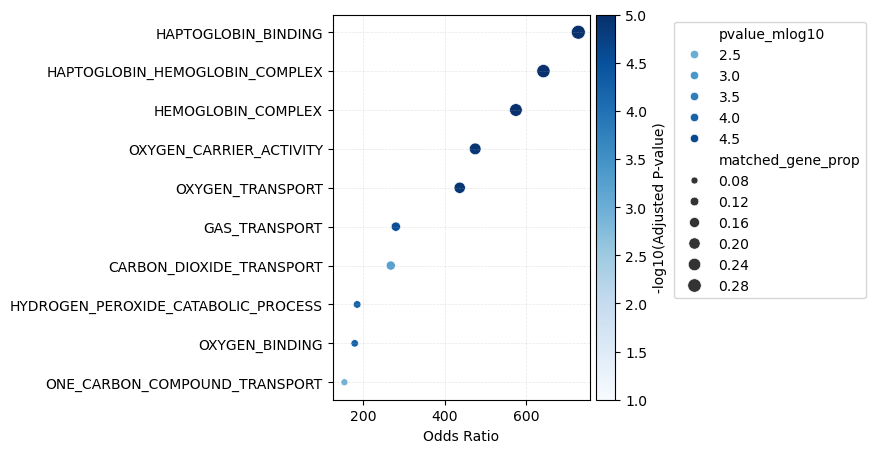

In [31]:
# Gene ontology enrichment analysis
print('Gene Ontology Enrichment Analysis')
plt.figure(figsize=(4, 5))
# all_gene_list = # var2grn_dedup_short[var2grn_dedup_short['PIP'] > 0.05]['TargetGene'].unique().tolist()
# trait = 'MCH'|
gene_list = list(K562_fp_atac_oneGene_var['TargetGene'].unique()) # list(K562_significant_fps_pivot[K562_significant_fps_pivot[trait] > 0]['TargetGene'].unique())
print(len(gene_list), 'number of genes')
enr = gp.enrichr(
            gene_list=gene_list,
            gene_sets='../FOODIE_20250407/GSEA_MSigDB/c5.go.v2025.1.Hs.symbols.gmt',  # see gp.get_library_name() for all
            organism='Human',
            cutoff=0.05,                # adjusted-p cutoff
        )
res2d_grp = enr.res2d
go_grp_sig = res2d_grp[res2d_grp['Adjusted P-value'] < 0.05].sort_values(by='Odds Ratio', ascending=False).reset_index(drop=True)
go_grp_sig['Term_split'] = go_grp_sig['Term'].str.split('_').apply(lambda x: '_'.join(x[1:7]) + '\n' + '_'.join(x[7:])  if len(x) > 7 else '_'.join(x[1:]))
go_grp_sig['matched_gene'] = go_grp_sig['Overlap'].str.split('/').str[0].astype(int)
go_grp_sig['total_gene'] = go_grp_sig['Overlap'].str.split('/').str[1].astype(int)
go_grp_sig['matched_gene_prop'] = go_grp_sig['matched_gene'] / go_grp_sig['total_gene']
go_grp_sig['pvalue_mlog10'] = -np.log10(go_grp_sig['Adjusted P-value'])
print(go_grp_sig.shape)
scatter = sns.scatterplot(
    data=go_grp_sig.head(10),
    x='Odds Ratio',
    y='Term_split',
    size='matched_gene_prop',
    hue='pvalue_mlog10',
    palette='Blues',
    sizes=(25, 100),
    hue_norm=(0, 5),
    legend='brief'  # Disable all legends
)
# Add size legend manually
# Add a heatmap-like colorbar for hue
norm = mpl.colors.Normalize(vmin=1, vmax=5)  # Same range as hue_norm
sm = mpl.cm.ScalarMappable(cmap='Blues', norm=norm)
# sm = mpl.cm.ScalarMappable(cmap='Blues')  <-- DELETE THIS LINE
sm.set_array([])  # Required for ScalarMappable

cbar = plt.colorbar(sm, ax=scatter, orientation='vertical', pad=0.02)
cbar.set_label('-log10(Adjusted P-value)', rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1.3, 1), ncol=1, frameon=True)
plt.grid(linewidth=0.5, linestyle='--', alpha=0.3)
plt.ylabel('')
plt.tight_layout()
plt.savefig('figure4_go_enrichment_erythroid_rarevariants.pdf',  bbox_inches='tight')

In [28]:
# retain only the driver rare variants associated with erythroid traits
K562_fp_atac_gene_loovar = K562_fp_atac_gene.merge(K562_erythroid_rarevars_valid_dedup, left_on='Name', right_on='Name_foodie')
K562_fp_atac_oneGene_loovar = K562_fp_atac_gene_loovar.sort_values(by=['SNP','ABC.Score'], ascending=[True, False]).drop_duplicates(subset=['SNP'], keep='first').reset_index(drop=True)
loovar_tfbs_alt_ref_effected_grn = K562_fp_atac_oneGene_loovar.merge(var_tfbs_alt_ref_all, left_on='SNP', right_on='rsID', how='left').reset_index(drop=True)
loovar_tfbs_alt_ref_effected_grn_filtered = loovar_tfbs_alt_ref_effected_grn[(loovar_tfbs_alt_ref_effected_grn['TF_change'] != 'Unchange')&(loovar_tfbs_alt_ref_effected_grn['ABC.Score']>0.015)].reset_index(drop=True)

In [29]:
K562_erythroid_rarevars_valid_dedup# ['variant_id'].nunique(

,SNP,Name_foodie
0,DRAGEN:chr16:234778:C:G,chr16:234776-234784
1,DRAGEN:chr16:88810611:G:A,chr16:88810600-88810618
2,DRAGEN:chr19:40807065:G:T,chr19:40807049-40807071
3,DRAGEN:chr6:27132003:G:A,chr6:27131998-27132010
4,DRAGEN:chr7:100125929:GT:G,chr7:100125924-100125951
5,DRAGEN:chr17:76264955:A:G,chr17:76264938-76264961
6,DRAGEN:chr6:139518262:G:A,chr6:139518237-139518267
7,DRAGEN:chr11:3379262:G:GC,chr11:3379254-3379274
8,DRAGEN:chr16:145021:C:T,chr16:145010-145040
9,DRAGEN:chr16:156415:T:C,chr16:156401-156424


In [59]:
K562_fp_atac_oneGene_loovar.shape # 45 driver rare variants in total

(21, 15)

In [60]:
# filtered out TFBS unaffected varaints
# loovar_tfbs_alt_ref_effected_grn_filtered                                                 ].reset_index(drop=True)

In [32]:
loovar_tfbs_alt_ref_effected_grn_filtered[['rsID','TF', 'TF_change', 'TF_K562_rna_tpm', 'TargetGene', 'ABC.Score.v1', 'distance', 'foodie_id']].to_csv('./final_results_260126/varTFBridge_results/K562_rarevar_TFBS_gene.csv', index=False)


In [45]:
loovar_tfbs_alt_ref_effected_grn_filtered[loovar_tfbs_alt_ref_effected_grn_filtered['TF_K562_rna_tpm'] > 0.5]['rsID'].nunique()

16

In [54]:
loovar_tfbs_alt_ref_effected_grn_filtered['rsID'].nunique()

18

In [35]:
# organize data for visualization
sel_cols = ['rsID', 'name', 'class', 'name', 'class',
       'TargetGene', 'distance', 'isSelfPromoter', 'hic_contact',
       'activity_base', 'ABC.Score', 'ABC.Score.v1', 'Name', 'foodie_id']
var_info_all = []
for rs_id in tqdm(loovar_tfbs_alt_ref_effected_grn_filtered['rsID'].unique()):
    var_data = loovar_tfbs_alt_ref_effected_grn_filtered[loovar_tfbs_alt_ref_effected_grn_filtered['rsID'] == rs_id]
    var_info = var_data[sel_cols].drop_duplicates().reset_index(drop=True)
    # var_data = var_data['TF']
    # print('Variant:', rs_id)
    tf_change_stats = dict(var_data.groupby('TF_change')['TF'].unique())
    change_str = []
    for tfc in tf_change_stats.keys():
        change_str.append(tfc + ':' + ','.join(tf_change_stats[tfc]))
    change_str = '|'.join(change_str)
    var_info['TF_changes'] = change_str
    var_info_all.append(var_info)
var_info_all = pd.concat(var_info_all).reset_index(drop=True)
var_info_all['Gene-TF'] = var_info_all['TargetGene'] + '-' + var_info_all['TF_changes']
for idx, row in var_info_all.iterrows():
    rsid = row['rsID']
    # print(rsid)
    rsid_fm_res = K562_erythroid_rarevars[K562_erythroid_rarevars['SNP'] == rsid].reset_index(drop=True)
    for _, row in rsid_fm_res.iterrows():
        trait = row['Trait']
        var_info_all.at[idx, trait] = row['LOG10P']

  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 180.55it/s]


In [36]:
var_info_all

,rsID,name,class,name,class,TargetGene,distance,isSelfPromoter,hic_contact,activity_base,...,MCHC,RBC,MSCV,RBCDW,HC,RP,HLDRC,HLSRP,HP,IRF
0,DRAGEN:chr11:3379262:G:GC,promoter|chr11:3378881-3379638,promoter,promoter|chr11:3378881-3379638,promoter,ZNF195,37.5,True,0.100131,9.856904,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DRAGEN:chr14:63543502:G:A,promoter|chr14:63542602-63543893,promoter,promoter|chr14:63542602-63543893,promoter,PPP2R5E,113.5,True,0.066104,9.196675,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,DRAGEN:chr16:145021:C:T,intergenic|chr16:144746-145389,intergenic,intergenic|chr16:144746-145389,intergenic,HBZ,7786.5,False,0.162586,3.446013,...,6.83435,13.32990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,DRAGEN:chr16:156415:T:C,intergenic|chr16:154938-157408,intergenic,intergenic|chr16:154938-157408,intergenic,HBZ,3319.0,False,0.071597,16.397443,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,DRAGEN:chr16:156520:C:T,intergenic|chr16:154938-157408,intergenic,intergenic|chr16:154938-157408,intergenic,HBZ,3319.0,False,0.071597,16.397443,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,DRAGEN:chr16:173004:AGAGGT:A,promoter|chr16:172724-173440,promoter,promoter|chr16:172724-173440,promoter,HBA2,236.0,True,0.122195,2.888111,...,14.97600,22.04640,6.90977,7.71566,NaN,NaN,NaN,NaN,NaN,NaN
6,DRAGEN:chr16:180725:G:C,promoter|chr16:178588-181832,promoter,promoter|chr16:178588-181832,promoter,HBQ1,123.0,True,0.096580,50.562675,...,18.05870,22.98550,NaN,7.46184,NaN,NaN,NaN,NaN,NaN,NaN
7,DRAGEN:chr16:234778:C:G,promoter|chr16:234218-235098,promoter,promoter|chr16:234218-235098,promoter,FAM234A,113.0,True,0.081317,9.272943,...,35.91980,46.98560,10.94720,10.48700,8.05962,7.15143,NaN,NaN,NaN,NaN
8,DRAGEN:chr16:234810:C:T,promoter|chr16:234218-235098,promoter,promoter|chr16:234218-235098,promoter,FAM234A,113.0,True,0.081317,9.272943,...,31.80570,50.04510,10.47950,12.43910,NaN,NaN,NaN,NaN,NaN,NaN
9,DRAGEN:chr16:234850:G:C,promoter|chr16:234218-235098,promoter,promoter|chr16:234218-235098,promoter,FAM234A,113.0,True,0.081317,9.272943,...,27.06910,38.35110,8.56296,8.91325,NaN,NaN,NaN,NaN,NaN,NaN


(18, 13)


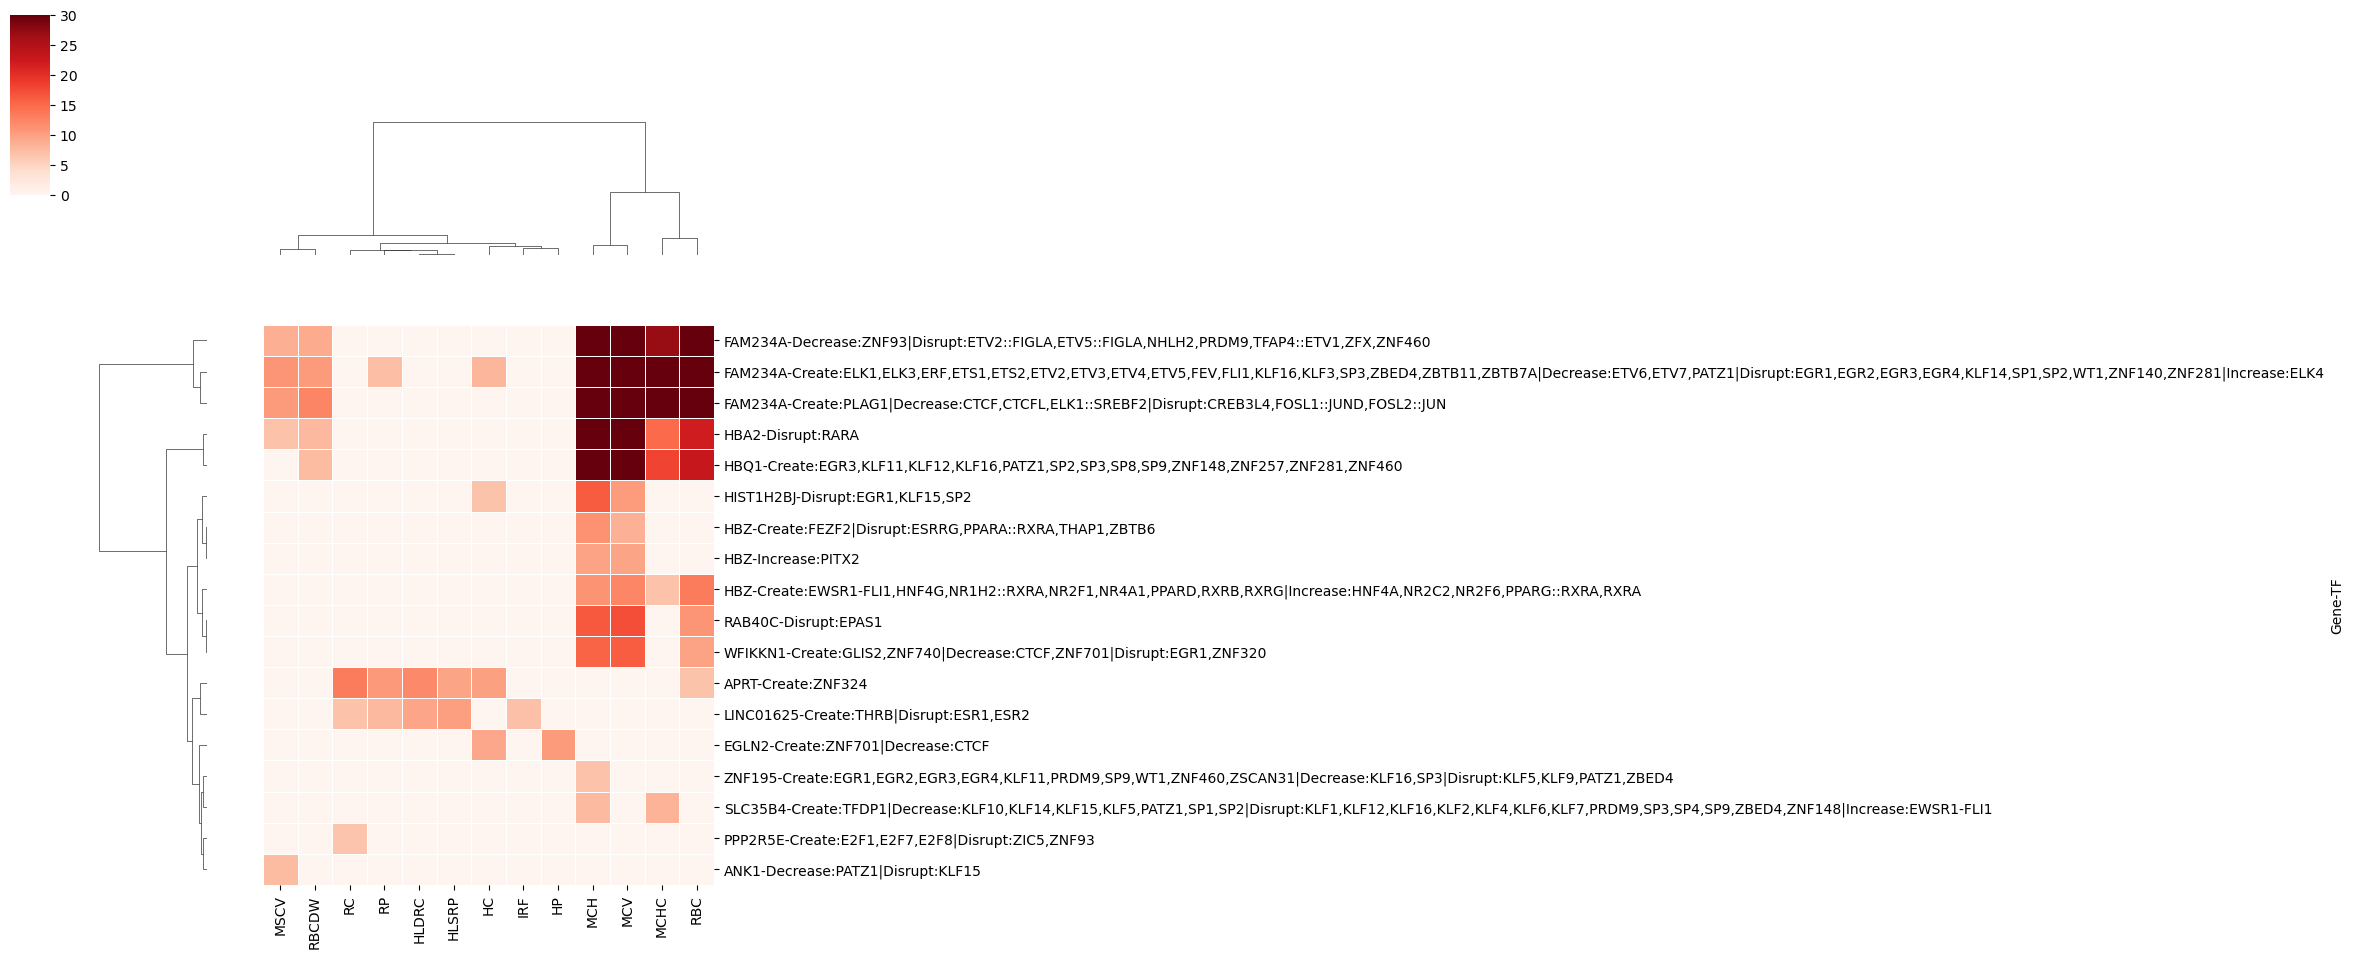

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster

# 假设 df 是你的 DataFrame，包含数值列
# 1) 预处理：去掉非数值列与缺失（可换成填充）

# df_num = gene_tf_trait
# 2) 双向层次聚类并画热图
#   - z_score=0 表示按行做 z-score 标准化（常见于表达矩阵/评分矩阵）
#   - 也可用 standard_scale=1 按列标准化；二者不要同时用
# gene_tf_trait = gene_tf_trait.T
# var_info_top30 = var_info_all.head(30)
gene_tf_trait = var_info_all.set_index('Gene-TF')[K562_erythroid_rarevars['Trait'].unique()].fillna(0)
print(gene_tf_trait.shape)
cg = sns.clustermap(
    gene_tf_trait,
    method="ward",          # 链接方法：ward/average/complete/single
    metric="euclidean",     # 距离：euclidean/manhattan/correlation 等
    # z_score=0,            # 按行标准化；如不需要，设为 None
    vmin=0,                 # Lower bound of the color scale
    vmax=30, 
    linewidths=.5,
    cmap="Reds",
    figsize=(8, 10)
)
plt.show()

# 3) 取回聚类后的顺序（用于重排 DataFrame 或后续分析）
row_order = cg.dendrogram_row.reordered_ind
col_order = cg.dendrogram_col.reordered_ind
df_reordered = gene_tf_trait.iloc[row_order, col_order]

# 4) 获取行/列的簇标签（剪树得到 k 个簇）
from scipy.cluster.hierarchy import fcluster

k_rows = 4
k_cols = 3

row_order = cg.dendrogram_row.reordered_ind
col_order = cg.dendrogram_col.reordered_ind
df_reordered = gene_tf_trait.iloc[row_order, col_order]

# 4) 获取行/列的簇标签（剪树得到 k 个簇）
from scipy.cluster.hierarchy import fcluster

k_rows = 4
k_cols = 3

row_labels = fcluster(cg.dendrogram_row.linkage, t=k_rows, criterion='maxclust')
col_labels = fcluster(cg.dendrogram_col.linkage, t=k_cols, criterion='maxclust')

row_labels = pd.Series(row_labels, index=gene_tf_trait.index)      # 与原行索引对齐
col_labels = pd.Series(col_labels, index=gene_tf_trait.columns)    # 与原列名对齐

# 可把标签并回原表
df_with_row_cluster = gene_tf_trait.copy()
df_with_row_cluster['row_cluster'] = row_labels

In [38]:
# df_reordered

In [39]:
K562_erythroid_rarevars_index = K562_erythroid_rarevars.set_index(['SNP', 'Trait'])
var_info = []
trait_list = K562_erythroid_rarevars['Trait'].unique().tolist()
for idx, row in var_info_all.iterrows():
    for trait in trait_list: 
        try:
            effect = K562_erythroid_rarevars_index.loc[(row['rsID'], trait), 'BETA']
            var_freq = K562_erythroid_rarevars_index.loc[(row['rsID'], trait), 'A1FREQ']
            logp = K562_erythroid_rarevars_index.loc[(row['rsID'], trait), 'LOG10P']
            delta_logp = K562_erythroid_rarevars_index.loc[(row['rsID'], trait), 'delta_LOG10P']
            var_info.append([row['rsID'], row['TF_changes'], row['TargetGene'], logp, delta_logp, row['ABC.Score.v1'], row['hic_contact'], row['activity_base'], effect, var_freq, trait])
        except:
            # print(row['rsID'], trait, 'not found')
            pass
var_info_df = pd.DataFrame(var_info, columns=['rsID', 'TF', 'TargetGene', 'MLOG10P', 'MLOG10P_delta', 'ABC.Score', 'hic_contact', 'activity_base', 'effect', 'freq', 'trait'])
var_info_df['Gene-TF'] = var_info_df['TargetGene'] + '-' + var_info_df['TF']

In [40]:
alphagenome_score = pd.read_csv('../FOODIE_20250407/alphagenome_score/K562_rareVar_sig_all_traits_for_alphagenome_score_K562EPI.csv.gz')
alphascore_H3k27ac = alphagenome_score[(alphagenome_score['biosample_name'] == 'K562')&(alphagenome_score['histone_mark'] == 'H3K27ac')].reset_index(drop=True)# ['quantile_score']
for idx, row in var_info_df.iterrows():
    snp_id = row['rsID'].replace('DRAGEN:', '')
    snp_id = ':'.join(snp_id.split(':')[:-1]) + '>' + snp_id.split(':')[-1]
    var_info_df.loc[idx, 'variant_id'] = snp_id
var_info_df = var_info_df.merge(alphascore_H3k27ac[['variant_id', 'histone_mark', 'raw_score', 'quantile_score']], on='variant_id').reset_index(drop=True)
alphagenome_tf_score = alphagenome_score[(alphagenome_score['biosample_name'] == 'K562')&(~alphagenome_score['transcription_factor'].isna())].reset_index(drop=True)#
alphagenome_tf_score = alphagenome_tf_score.merge(var_info_df[['rsID', 'variant_id']], on='variant_id')

In [42]:
alphagenome_tf_score_expr = alphagenome_tf_score.merge(TF_K562_GM12878_merged, left_on='transcription_factor', right_on='TF', how='left').reset_index(drop=True)

In [43]:
len(alphagenome_tf_score[abs(alphagenome_tf_score['quantile_score'])>0.9]['transcription_factor'])

5883

In [47]:
var_info_df['variant_id'].nunique()

18

In [51]:
alphagenome_tf_score[alphagenome_tf_score['variant_id'].isin(var_info_df['variant_id'].unique())].drop(columns=['Unnamed: 0']).to_csv('./final_results_260126/Supplementary Data 3.tsv', sep='\t', index=False)

In [67]:
# plt.figure(figsize=(6, 9)) 
# norm = mpl.colors.Normalize(vmin=-1.0, vmax=1.0) 
# ax = sns.scatterplot(data=alphagenome_tf_score, y='variant_id', x='raw_score',
#             hue='quantile_score', palette='coolwarm', hue_norm=norm, s=15, alpha=0.6)
# ax.margins(y=0.02)
# plt.xticks(rotation=90)
# plt.grid(axis='x', linestyle='--', alpha=0.3)
# # move legend outside
# # plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., title='Quantile Score')
# plt.tight_layout()

In [68]:
# alphagenome_tf_score[alphagenome_tf_score['quantile_score'] > 0.8]['variant_id'].nunique()

In [72]:
for rsid in loovar_tfbs_alt_ref_effected_grn_filtered['rsID'].unique():
    var_alpha = alphagenome_tf_score[alphagenome_tf_score['rsID'] == rsid]# .reset_index(drop=True)
    var_tfbridge = loovar_tfbs_alt_ref_effected_grn_filtered[loovar_tfbs_alt_ref_effected_grn_filtered['rsID'] == rsid].reset_index(drop=True)
    for _, row1 in var_tfbridge.iterrows():
        for tf in row1['TF'].split('::'):
            for idx, row2 in var_alpha.iterrows():
                if tf == row2['transcription_factor']:
                    alphagenome_tf_score.at[idx, 'tfbs_change'] = row1['TF_change']
                    break
alphagenome_tf_score['tfbs_change'] = alphagenome_tf_score['tfbs_change'].fillna('Unchange')

In [ ]:
loovar_tfbs_alt_ref_effected_grn_filtered['rsID'].nunique(), loovar_tfbs_alt_ref_effected_grn_filtered['foodie_id'].nunique() he jia huan le

(18, 18)

In [94]:
alphagenome_tf_score[(alphagenome_tf_score['tfbs_change'] != 'Unchange')&(abs(alphagenome_tf_score['quantile_score'])>0.8)]['transcription_factor'].unique()


array(['EGR1', 'ETV5', 'ETV6', 'KLF16', 'SP1', 'ZBTB11', 'ZBTB7A',
       'ZNF281', 'CTCF', 'ZNF148', 'ZNF740', 'NR2C2', 'NR2F1', 'NR2F6',
       'NR4A1', 'E2F1'], dtype=object)

In [93]:
alphagenome_tf_score[(alphagenome_tf_score['tfbs_change'] != 'Unchange')&(abs(alphagenome_tf_score['quantile_score'])>0.9)]['transcription_factor'].unique()

array(['EGR1', 'KLF16', 'SP1', 'ZBTB11', 'ZNF281', 'CTCF', 'ZNF148',
       'NR2C2', 'NR2F1', 'NR2F6', 'NR4A1', 'E2F1'], dtype=object)

In [71]:
# plt.figure(figsize=(6, 9))
# # all_comvar_K562_tfbsALT_agTF_filtered = all_comvar_K562_tfbsALT_agTF[abs(all_comvar_K562_tfbsALT_agTF['quantile_score']) > 0.9].reset_index()
# norm = mpl.colors.Normalize(vmin=-1.0, vmax=1.0) 
# unchanged_tfbs = alphagenome_tf_score[alphagenome_tf_score['tfbs_change'] == 'Unchange'].reset_index(drop=True)
# decreased_tfbs = alphagenome_tf_score[alphagenome_tf_score['tfbs_change'] == 'Decrease'].reset_index(drop=True)
# increased_tfbs = alphagenome_tf_score[alphagenome_tf_score['tfbs_change'] == 'Increase'].reset_index(drop=True)
# disrupted_tfbs = alphagenome_tf_score[alphagenome_tf_score['tfbs_change'] == 'Disrupt'].reset_index(drop=True)
# create_tfbs = alphagenome_tf_score[alphagenome_tf_score['tfbs_change'] == 'Create'].reset_index(drop=True)
# ax = sns.scatterplot(data=alphagenome_tf_score, y='variant_id', x='raw_score',
#             hue='quantile_score', palette='coolwarm', hue_norm=norm, s=15, alpha=0.6)
# sns.scatterplot(data=unchanged_tfbs, y='variant_id', x='raw_score',  hue='quantile_score',  palette='coolwarm', hue_norm=norm, marker='o', s=15, ax=ax, alpha=0.1, legend=False, label='Unchange')
# sns.scatterplot(data=decreased_tfbs, y='variant_id', x='raw_score',  hue='quantile_score',  palette='coolwarm', hue_norm=norm, marker='v', s=45, ax=ax, alpha=0.8, linewidth=1, edgecolors='black', legend=False, label='Decrease')
# sns.scatterplot(data=increased_tfbs, y='variant_id', x='raw_score',  hue='quantile_score',  palette='coolwarm', hue_norm=norm, marker='^', s=45, ax=ax, alpha=0.8, linewidth=1, edgecolors='black', legend=False, label='Increase')
# sns.scatterplot(data=disrupted_tfbs, y='variant_id', x='raw_score',  hue='quantile_score',  palette='coolwarm', hue_norm=norm, marker='X', s=45, ax=ax, alpha=0.8, linewidth=1, edgecolors='black', legend=False, label='Disrupt')
# sns.scatterplot(data=create_tfbs, y='variant_id', x='raw_score',  hue='quantile_score',  palette='coolwarm', hue_norm=norm, marker='*', s=70, ax=ax, alpha=0.8, linewidth=1, edgecolors='black', legend=False, label='Create')
# ax.margins(y=0.02)
# plt.xticks(rotation=90)
# plt.grid(axis='x', linestyle='--', alpha=0.3, zorder=0)
# # move legend outside 
# # plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0)  
# plt.ylabel('')
# plt.xlabel('Driver rare variant') # Variant
# plt.tight_layout()

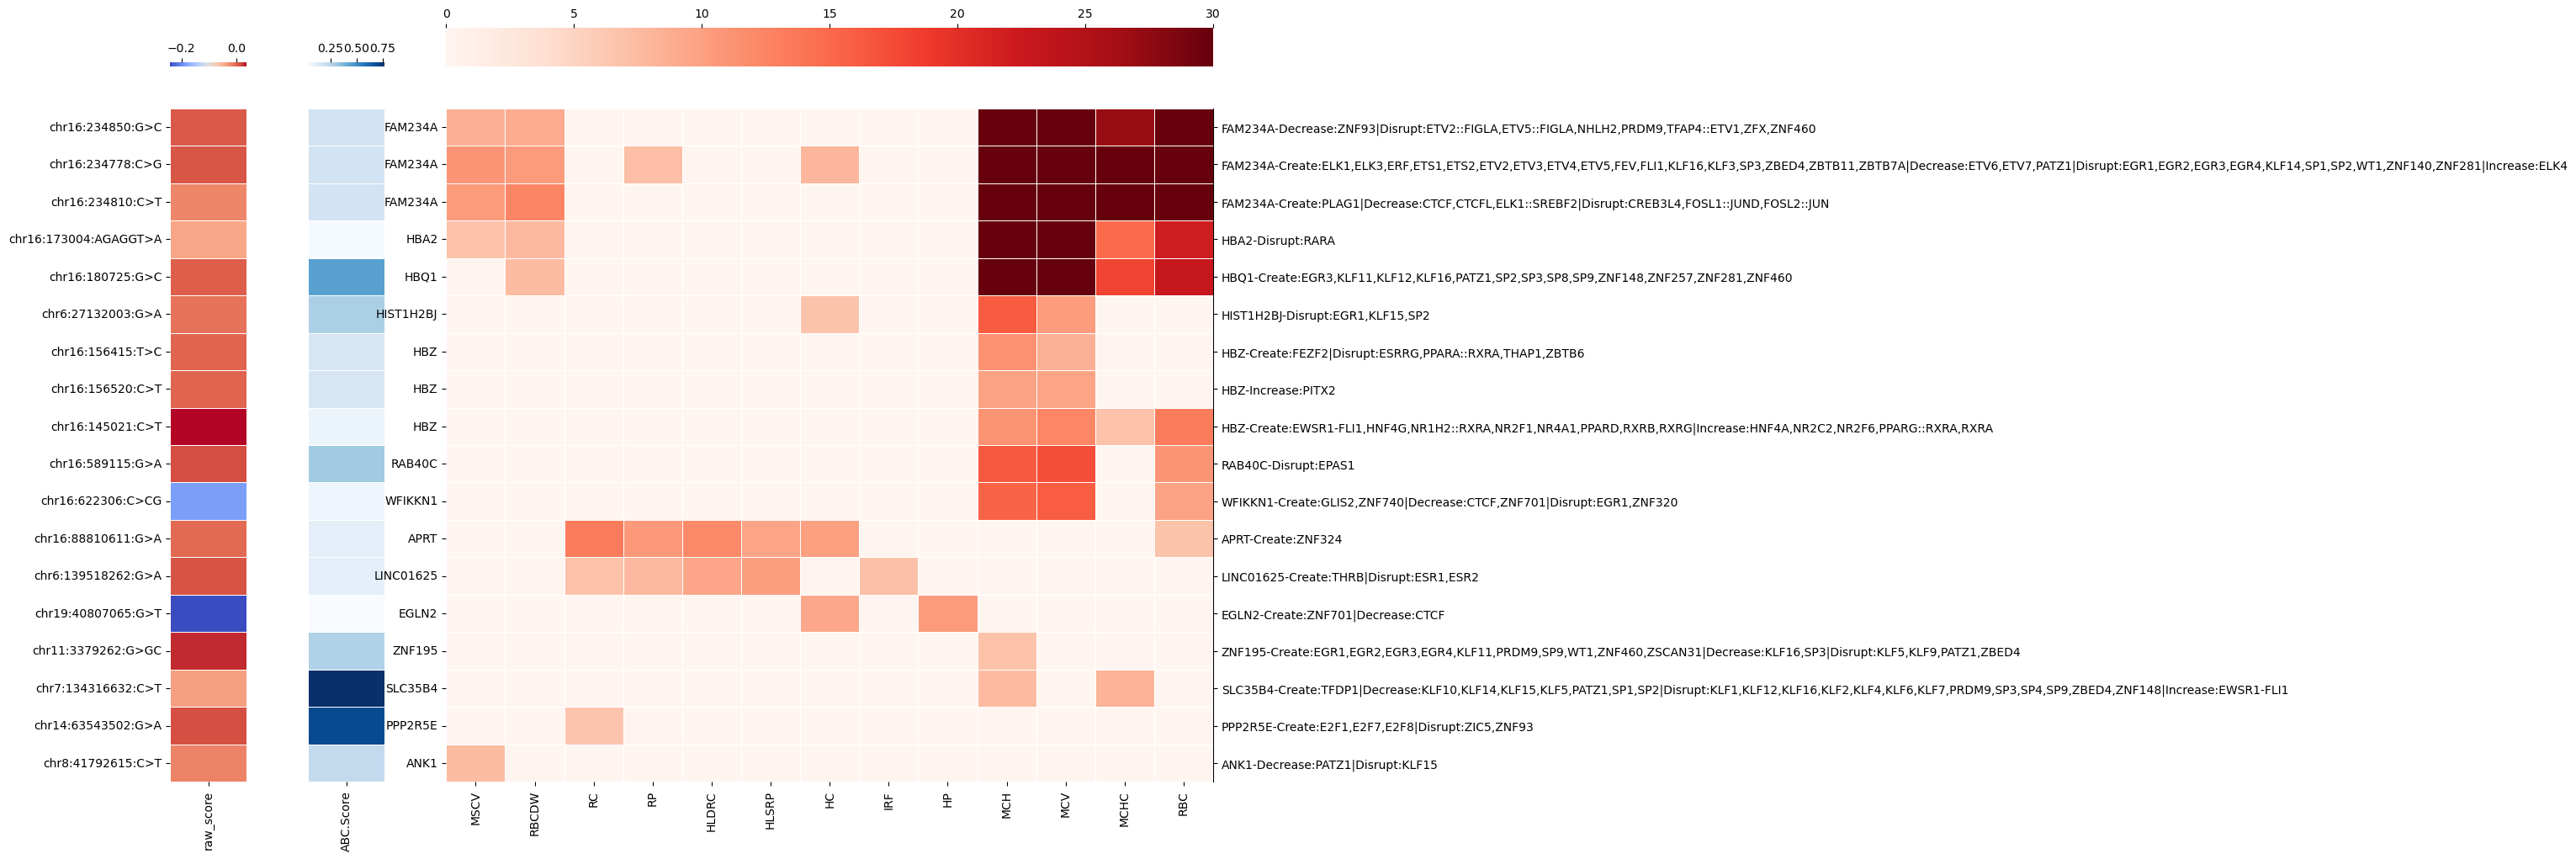

In [95]:
from matplotlib.colors import ListedColormap
# Define the desired order for the 'trait' column
desired_trait_order = df_reordered.columns  # Replace with your desired order if different
var_info_df = var_info_df.set_index('Gene-TF').loc[df_reordered.index].reset_index()
# Set the 'trait' column as a categorical variable with the desired order
var_info_df['trait'] = pd.Categorical(var_info_df['trait'], categories=desired_trait_order, ordered=True)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(16, 13), gridspec_kw={'width_ratios': [1, 1, 10]})  # Adjust height ratios

sns.heatmap(
    data=var_info_df.drop_duplicates(subset=['variant_id']).set_index('Gene-TF').loc[df_reordered.index][['variant_id', 'raw_score']].set_index('variant_id'),  # Replace with your ABC.core DataFrame
    cmap='coolwarm',
    cbar=True,
    # cbar_kws={'label': 'alphagenome'},
    ax=axes[0],  # Use the second subplot
    xticklabels=True,
    yticklabels=True,
    linewidths=0.5,
    cbar_kws={'location': 'top'},
)
# add cbar outside
# axes[0].set_xlabel('alphagenome H3K27ac score')
axes[0].set_ylabel('')
axes[0].tick_params(axis='x', labelrotation=90)

sns.heatmap(
    data=var_info_df.drop_duplicates(subset=['variant_id']).set_index('Gene-TF').loc[df_reordered.index][['variant_id', 'ABC.Score']].set_index('variant_id'),  # Replace with your ABC.core DataFrame
    cmap='Blues',
    cbar=True,
    # cbar_kws={'label': 'ABC Score'},
    ax=axes[1],  # Use the second subplot
    xticklabels=True,
    yticklabels=True,
    linewidths=0.5,
    cbar_kws={'location': 'top'},
)
axes[1].set_ylabel('')
axes[1].set_yticks([])
axes[1].tick_params(axis='x', labelrotation=90)

# axes[0].legend(
#     bbox_to_anchor=(0.9, 1.08),  # Center the legend horizontally and move it above the plot
#     # loc='center',  # Align the legend to the center
#     # borderaxespad=0.,
#     # title='PIP'  # Add a title to the legend
# )
# Top subplot: Scatter plot
# sns.scatterplot(
#     data=var_info_df,
#     x='trait',
#     y='Gene-TF',
#     hue='MLOG10P',
#     size='MLOG10P',
#     alpha=0.7,
#     sizes=(10, 150),
#     linewidth=1,
#     hue_norm=(0, 1),
#     edgecolors='black',
#     palette='Reds',
#     ax=axes[2]  # Use the first subplot
# )
sns.heatmap(df_reordered, cmap='Reds', annot=False,  linewidths=.5, cbar_kws={'location': 'top'}, vmax=30, ax=axes[2], cbar=True)  # Use the first subplot) 

yticks = axes[2].get_yticks()
yticklabels = [t.get_text() for t in axes[2].get_yticklabels()]

new_ylabels = var_info_df.drop_duplicates(subset=['variant_id', 'hic_contact'])['TargetGene'].tolist()

# 2. Set the tick positions to be in the center of each row (0.5, 1.5, ...)
axes[2].set_yticks([i + 0.5 for i in range(len(new_ylabels))])

# 3. Set the labels with desired formatting
axes[2].set_yticklabels(new_ylabels, rotation=0, fontsize=10)
# --- CHANGED CODE END ---

# yticks = axes[2].get_yticks()
# yticklabels = [t.get_text() for t in axes[1].get_yticklabels()]

# hide left labels
# Add a secondary x-axis at the top
ax_right = axes[2].secondary_yaxis('right')
ax_right.set_yticks(axes[2].get_yticks())
ax_right.set_yticklabels(yticklabels) # yticklabels)
# # ax_right.set_ylabel('Transcription factor')  # Label for the top x-axis
axes[2].set_yticklabels(var_info_df.drop_duplicates(subset=['variant_id', 'hic_contact'])['TargetGene'])
axes[2].set_ylabel('')
axes[2].set_xlabel('')

# Optional: move them a bit right by adding padding

# axes[2].set_ylim(-0.5, 29.5)
axes[2].tick_params(axis='x', labelrotation=90)

# Add a secondary x-axis at the top
# ax_top = axes[0].secondary_xaxis('top')
# ax_top.set_xticks(axes[0].get_xticks())
# ax_top.set_xticklabels(axes[0].get_xticklabels(), rotation=90, ha='center')
# ax_top.set_xlabel('Transcription factor')  # Label for the top x-axis

# Bottom subplot: ABC.core data
# add cbar outside
# axes[1].set_xlabel('Gene-TF')
# # Define a colormap for the categories``
# category_colors = ListedColormap(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])  # Example colors

# category_mapping = {category: idx for idx, category in enumerate(var_info_df['TF_change'].unique())}
# var_info_df['TF_change_numeric'] = var_info_df['TF_change'].map(category_mapping)
# axes[1].set_ylabel('ABC.core Features')
# sns.heatmap(
#     data=var_info_df[['Gene-TF', 'TF', 'TF_change_numeric']].drop_duplicates().set_index('TF').drop(columns=['Gene-TF']).T,  # Use numeric values for heatmap
#     cmap=category_colors,  # Use the categorical colormap
#     cbar=False,
#     cbar_kws={'label': 'TF Change'},
#     ax=axes[2],  # Use the third subplot
#     xticklabels=True,
#     yticklabels=True,
#     linewidths=0.5,

# )
# add cbar outside
# axes[2].set_xlabel('TF')

# Adjust layout
plt.tight_layout()
# plt.savefig('figure5_rarevar2grn.pdf', transparent=True, format='pdf', bbox_inches='tight')

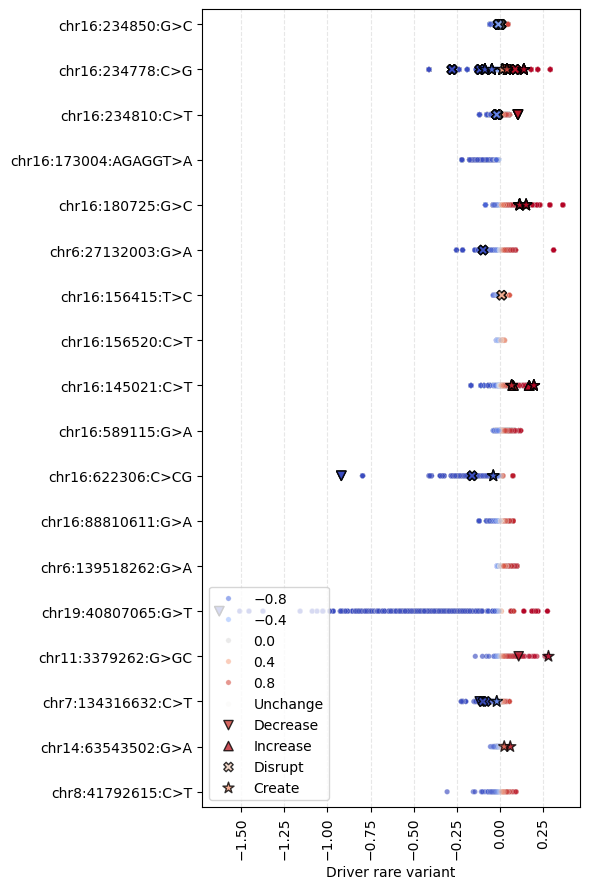

In [73]:
alphagenome_tf_score_ordered = alphagenome_tf_score.set_index('variant_id').loc[var_info_df['variant_id']].reset_index()
plt.figure(figsize=(6, 9))
# all_comvar_K562_tfbsALT_agTF_filtered = all_comvar_K562_tfbsALT_agTF[abs(all_comvar_K562_tfbsALT_agTF['quantile_score']) > 0.9].reset_index()
norm = mpl.colors.Normalize(vmin=-1.0, vmax=1.0) 
unchanged_tfbs = alphagenome_tf_score_ordered[alphagenome_tf_score_ordered['tfbs_change'] == 'Unchange'].reset_index(drop=True)
decreased_tfbs = alphagenome_tf_score_ordered[alphagenome_tf_score_ordered['tfbs_change'] == 'Decrease'].reset_index(drop=True)
increased_tfbs = alphagenome_tf_score_ordered[alphagenome_tf_score_ordered['tfbs_change'] == 'Increase'].reset_index(drop=True)
disrupted_tfbs = alphagenome_tf_score_ordered[alphagenome_tf_score_ordered['tfbs_change'] == 'Disrupt'].reset_index(drop=True)
create_tfbs = alphagenome_tf_score_ordered[alphagenome_tf_score_ordered['tfbs_change'] == 'Create'].reset_index(drop=True)
ax = sns.scatterplot(data=alphagenome_tf_score_ordered, y='variant_id', x='raw_score',
            hue='quantile_score', palette='coolwarm', hue_norm=norm, s=15, alpha=0.6)
sns.scatterplot(data=unchanged_tfbs, y='variant_id', x='raw_score',  hue='quantile_score',  palette='coolwarm', hue_norm=norm, marker='o', s=15, ax=ax, alpha=0.1, legend=False, label='Unchange')
sns.scatterplot(data=decreased_tfbs, y='variant_id', x='raw_score',  hue='quantile_score',  palette='coolwarm', hue_norm=norm, marker='v', s=45, ax=ax, alpha=0.8, linewidth=1, edgecolors='black', legend=False, label='Decrease')
sns.scatterplot(data=increased_tfbs, y='variant_id', x='raw_score',  hue='quantile_score',  palette='coolwarm', hue_norm=norm, marker='^', s=45, ax=ax, alpha=0.8, linewidth=1, edgecolors='black', legend=False, label='Increase')
sns.scatterplot(data=disrupted_tfbs, y='variant_id', x='raw_score',  hue='quantile_score',  palette='coolwarm', hue_norm=norm, marker='X', s=45, ax=ax, alpha=0.8, linewidth=1, edgecolors='black', legend=False, label='Disrupt')
sns.scatterplot(data=create_tfbs, y='variant_id', x='raw_score',  hue='quantile_score',  palette='coolwarm', hue_norm=norm, marker='*', s=70, ax=ax, alpha=0.8, linewidth=1, edgecolors='black', legend=False, label='Create')
ax.margins(y=0.02)
plt.xticks(rotation=90)
plt.grid(axis='x', linestyle='--', alpha=0.3, zorder=0)
# move legend outside 
# plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0)  
plt.legend(loc='lower left')
plt.ylabel('')
plt.xlabel('Driver rare variant') # Variant
plt.tight_layout()

In [53]:
# var_info_df.columns

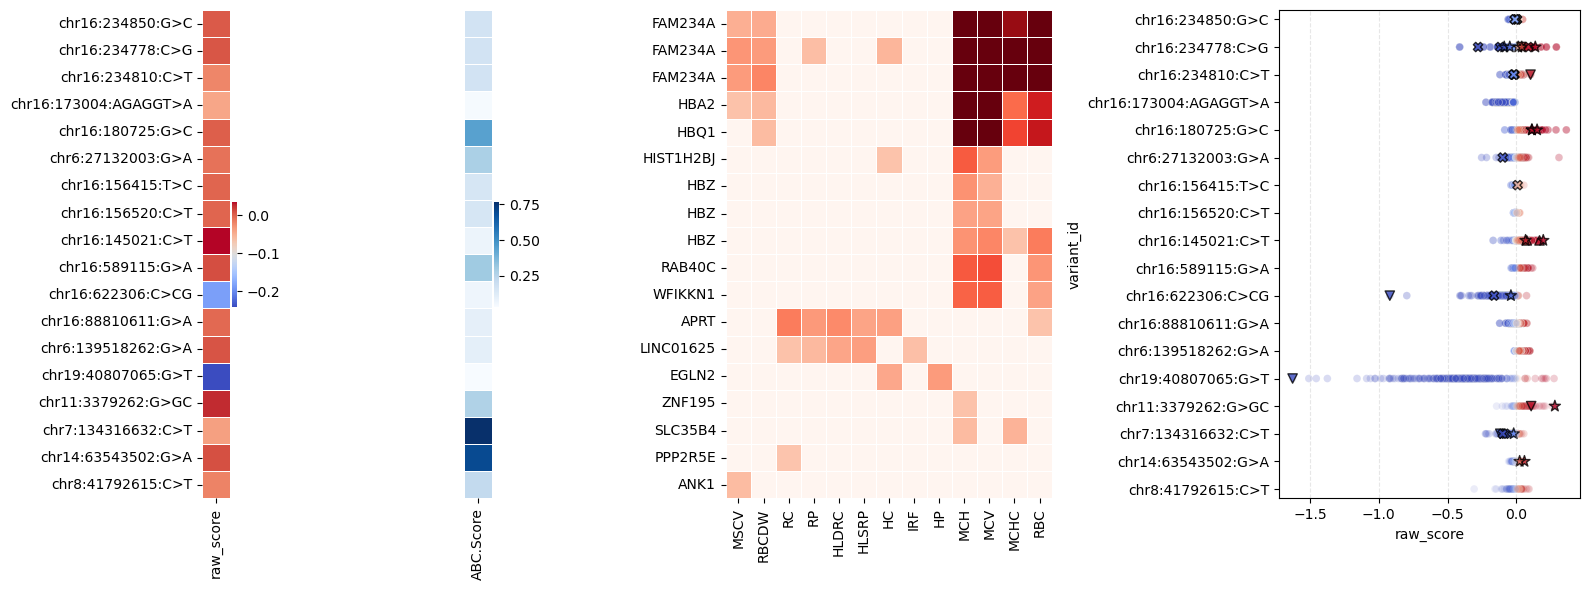

In [96]:
from matplotlib.colors import ListedColormap
var_info_df['effect_direction'] = var_info_df['effect']>0 
# Define the desired order for the 'trait' column
desired_trait_order = df_reordered.columns  # Replace with your desired order if different
var_info_df = var_info_df.set_index('Gene-TF').loc[df_reordered.index].reset_index()
# Set the 'trait' column as a categorical variable with the desired order
var_info_df['trait'] = pd.Categorical(var_info_df['trait'], categories=desired_trait_order, ordered=True)

# Create subplots
fig, axes = plt.subplots(1, 4, figsize=(16, 6), gridspec_kw={'width_ratios': [0.7, 0.7, 6.5, 6]})  # Adjust height ratios
variant_order = var_info_df.drop_duplicates(subset=['variant_id']).set_index('Gene-TF').loc[df_reordered.index[::-1]][['variant_id', 'raw_score']].set_index('variant_id').index[::-1]

sns.heatmap(
    data=var_info_df.drop_duplicates(subset=['variant_id']).set_index('Gene-TF').loc[df_reordered.index][['variant_id', 'raw_score']].set_index('variant_id'),  # Replace with your ABC.core DataFrame
    cmap='coolwarm',
    cbar=True,
    # cbar_kws={'label': 'alphagenome'},
    ax=axes[0],  # Use the second subplot
    xticklabels=True,
    yticklabels=True,
    linewidths=0.5,
)
# add cbar outside
# axes[0].set_xlabel('alphagenome H3K27ac score')
axes[0].set_ylabel('')
axes[0].tick_params(axis='x', labelrotation=90)

sns.heatmap(
    data=var_info_df.drop_duplicates(subset=['variant_id']).set_index('Gene-TF').loc[df_reordered.index][['variant_id', 'ABC.Score']].set_index('variant_id'),  # Replace with your ABC.core DataFrame
    cmap='Blues',
    cbar=True,
    # cbar_kws={'label': 'ABC Score'},
    ax=axes[1],  # Use the second subplot
    xticklabels=True,
    yticklabels=True,
    linewidths=0.5,
)
axes[1].set_ylabel('')
axes[1].set_yticks([])
axes[1].tick_params(axis='x', labelrotation=90)
# axes[0].legend(
#     bbox_to_anchor=(0.9, 1.08),  # Center the legend horizontally and move it above the plot
#     # loc='center',  # Align the legend to the center
#     # borderaxespad=0.,
#     # title='PIP'  # Add a title to the legend
# )
# Top subplot: Scatter plot
# marker_map = {False: 'v', True: '^'}
# sns.scatterplot(
#     data=var_info_df,
#     x='trait',
#     y='Gene-TF',
#     hue='PIP',
#     size='PIP',
#     alpha=0.7,
#     sizes=(10, 150),
#     style='effect_direction',
#     markers=marker_map,
#     linewidth=0.6,
#     hue_norm=(0, 1),
#     edgecolors='black',
#     palette='Reds',
#     ax=axes[2]  # Use the first subplot
# )
sns.heatmap(df_reordered, cmap='Reds', annot=False,  linewidths=.7, cbar_kws={'location': 'top'}, vmax=30, ax=axes[2], cbar=False)  # Use the first subplot) 

yticks = axes[2].get_yticks()
yticklabels = [t.get_text() for t in axes[2].get_yticklabels()]

new_ylabels = var_info_df.drop_duplicates(subset=['variant_id', 'hic_contact'])['TargetGene'].tolist()
axes[2].set_yticklabels(var_info_df.drop_duplicates(subset=['variant_id', 'hic_contact'])['TargetGene'])
axes[2].set_ylabel('')
axes[2].set_xlabel('')
# 2. Set the tick positions to be in the center of each row (0.5, 1.5, ...)
# axes[2].set_yticks([i + 0.5 for i in range(len(new_ylabels))])

# 3. Set the labels with desired formatting
# axes[2].set_yticklabels(new_ylabels, rotation=0, fontsize=10)
# --- CHANGED CODE END ---

# yticks = axes[2].get_yticks()
# yticklabels = [t.get_text() for t in axes[1].get_yticklabels()]

# hide left labels
# Add a secondary x-axis at the top
# ax_right = axes[2].secondary_yaxis('right')
# ax_right.set_yticks(axes[2].get_yticks())
# ax_right.set_yticklabels(yticklabels) # yticklabels)
# # ax_right.set_ylabel('Transcription factor')  # Label for the top x-axis
axes[2].set_yticklabels(var_info_df.drop_duplicates(subset=['variant_id', 'hic_contact'])['TargetGene'])
axes[2].set_ylabel('')
axes[2].set_xlabel('')

# Optional: move them a bit right by adding padding
# ax_top.tick_params(axis='x', pad=10)   # increase pad to push labels further away
# axes[2].legend(
#     bbox_to_anchor=(0.9, 1.1),  # Center the legend horizontally and move it above the plot
#     loc='center',  # Align the legend to the center
#     borderaxespad=0.,
#     # title='PIP'  # Add a title to the legend
# )
# axes[2].set_ylim(-0.5, 29.5)
axes[2].tick_params(axis='x', labelrotation=90)
# share y axis
alphagenome_tf_score_ordered = alphagenome_tf_score.set_index('variant_id').loc[variant_order].reset_index()
norm = mpl.colors.Normalize(vmin=-1.0, vmax=1.0) 
unchanged_tfbs = alphagenome_tf_score_ordered[alphagenome_tf_score_ordered['tfbs_change'] == 'Unchange'].reset_index(drop=True)
decreased_tfbs = alphagenome_tf_score_ordered[alphagenome_tf_score_ordered['tfbs_change'] == 'Decrease'].reset_index(drop=True)
increased_tfbs = alphagenome_tf_score_ordered[alphagenome_tf_score_ordered['tfbs_change'] == 'Increase'].reset_index(drop=True)
disrupted_tfbs = alphagenome_tf_score_ordered[alphagenome_tf_score_ordered['tfbs_change'] == 'Disrupt'].reset_index(drop=True)
create_tfbs = alphagenome_tf_score_ordered[alphagenome_tf_score_ordered['tfbs_change'] == 'Create'].reset_index(drop=True)
# sns.scatterplot(data=alphagenome_tf_score_ordered, y='variant_id', x='raw_score',
#             hue='quantile_score', palette='coolwarm', hue_norm=norm, s=15, alpha=0.6, ax=axes[3])
sns.scatterplot(data=unchanged_tfbs, y='variant_id', x='raw_score',  hue='quantile_score',  palette='coolwarm', hue_norm=norm, marker='o', s=30, ax=axes[3], alpha=0.1, legend=False, label='Unchange')
sns.scatterplot(data=decreased_tfbs, y='variant_id', x='raw_score',  hue='quantile_score',  palette='coolwarm', hue_norm=norm, marker='v', s=45, ax=axes[3], alpha=0.8, linewidth=1, edgecolors='black', legend=False, label='Decrease')
sns.scatterplot(data=increased_tfbs, y='variant_id', x='raw_score',  hue='quantile_score',  palette='coolwarm', hue_norm=norm, marker='^', s=45, ax=axes[3], alpha=0.8, linewidth=1, edgecolors='black', legend=False, label='Increase')
sns.scatterplot(data=disrupted_tfbs, y='variant_id', x='raw_score',  hue='quantile_score',  palette='coolwarm', hue_norm=norm, marker='X', s=45, ax=axes[3], alpha=0.8, linewidth=1, edgecolors='black', legend=False, label='Disrupt')
sns.scatterplot(data=create_tfbs, y='variant_id', x='raw_score',  hue='quantile_score',  palette='coolwarm', hue_norm=norm, marker='*', s=70, ax=axes[3], alpha=0.8, linewidth=1, edgecolors='black', legend=False, label='Create')
# set grid
axes[3].grid(axis='x', linestyle='--', alpha=0.3)
# -ax = sns.scatterplot(data=alphascore_top30_dedup, y='rsID', x='raw_score', hue='quantile_score', palette='vlag', s=15, alpha=0.5, hue_norm=norm) # vlag
axes[3].margins(y=0.02)
# plt.xticks(rotation=90)
# plt.grid(axis='x', linestyle='--', alpha=0.3)
# move legend outside
# axes[3].legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., title='Quantile Score')
# plt.tight_layout()

# Adjust layout
plt.tight_layout()
plt.savefig('figure4_rarevar2grn_alphagenome.pdf', transparent=True, format='pdf', bbox_inches='tight')

In [102]:
var_info_df['effect_direct'] = var_info_df['effect']>0
var_info_df[['variant_id', 'effect', 'trait', 'effect_direct']].to_csv('./rarevar_effect_direct.csv', index=False, sep='\t')

In [76]:
# tt = alphagenome_tf_score_ordered[alphagenome_tf_score_ordered['variant_id'] == 'chr16:145021:C>T'].reset_index(drop=True)
# tt[tt['tfbs_change']!= 'Unchange']

In [46]:
var_info_df[var_info_df['variant_id'].isin(['chr16:145021:C>T', 'chr16:145017:C>T'])]

,Gene-TF,rsID,TF,TargetGene,MLOG10P,MLOG10P_delta,ABC.Score,hic_contact,activity_base,effect,freq,trait,variant_id,histone_mark,raw_score,quantile_score,effect_direction
44,"HBZ-Create:ZFP809,ZNF184",DRAGEN:chr16:145017:C:T,"Create:ZFP809,ZNF184",HBZ,11.16610,-0.329000,0.074122,0.162586,3.446013,-0.231618,0.000811,MCH,chr16:145017:C>T,H3K27ac,-0.057055,-0.978005,False
45,"HBZ-Create:ZFP809,ZNF184",DRAGEN:chr16:145017:C:T,"Create:ZFP809,ZNF184",HBZ,12.39560,-0.213900,0.074122,0.162586,3.446013,-0.246094,0.000811,MCV,chr16:145017:C>T,H3K27ac,-0.057055,-0.978005,False
46,"HBZ-Create:ZFP809,ZNF184",DRAGEN:chr16:145017:C:T,"Create:ZFP809,ZNF184",HBZ,6.83435,-0.365950,0.074122,0.162586,3.446013,-0.195410,0.000811,MCHC,chr16:145017:C>T,H3K27ac,-0.057055,-0.978005,False
47,"HBZ-Create:ZFP809,ZNF184",DRAGEN:chr16:145017:C:T,"Create:ZFP809,ZNF184",HBZ,13.32990,0.108700,0.074122,0.162586,3.446013,0.265259,0.000811,RBC,chr16:145017:C>T,H3K27ac,-0.057055,-0.978005,True
48,"HBZ-Create:EWSR1-FLI1,HNF4G,NR1H2::RXRA,NR2F1,...",DRAGEN:chr16:145021:C:T,"Create:EWSR1-FLI1,HNF4G,NR1H2::RXRA,NR2F1,NR4A...",HBZ,11.16610,-10.303820,0.074122,0.162586,3.446013,-0.231618,0.000811,MCH,chr16:145021:C>T,H3K27ac,0.035782,0.954525,False
49,"HBZ-Create:EWSR1-FLI1,HNF4G,NR1H2::RXRA,NR2F1,...",DRAGEN:chr16:145021:C:T,"Create:EWSR1-FLI1,HNF4G,NR1H2::RXRA,NR2F1,NR4A...",HBZ,12.39560,-11.144760,0.074122,0.162586,3.446013,-0.246094,0.000811,MCV,chr16:145021:C>T,H3K27ac,0.035782,0.954525,False
50,"HBZ-Create:EWSR1-FLI1,HNF4G,NR1H2::RXRA,NR2F1,...",DRAGEN:chr16:145021:C:T,"Create:EWSR1-FLI1,HNF4G,NR1H2::RXRA,NR2F1,NR4A...",HBZ,6.83435,-6.723426,0.074122,0.162586,3.446013,-0.195410,0.000811,MCHC,chr16:145021:C>T,H3K27ac,0.035782,0.954525,False
51,"HBZ-Create:EWSR1-FLI1,HNF4G,NR1H2::RXRA,NR2F1,...",DRAGEN:chr16:145021:C:T,"Create:EWSR1-FLI1,HNF4G,NR1H2::RXRA,NR2F1,NR4A...",HBZ,13.32990,-12.544101,0.074122,0.162586,3.446013,0.265259,0.000811,RBC,chr16:145021:C>T,H3K27ac,0.035782,0.954525,True


In [110]:
K562_erythroid_rarevars_valid_dedup[K562_erythroid_rarevars_valid_dedup['SNP'].isin(['DRAGEN:chr16:145021:C:T', 'DRAGEN:chr16:145017:C:T'])]

,SNP,Name_foodie
23,DRAGEN:chr16:145021:C:T,chr16:145010-145040


In [130]:
TF_K562_GM12878_merged

,TF,K562_rna_rpkm,GM12878_rna_rpkm,K562_rna_tpm,GM12878_rna_tpm
0,MYB,37.209,9.219,10.369400,1.482840
1,AR,0.002,0.018,0.006478,0.028544
2,EHF,0.029,0.009,0.063468,0.063926
3,FOXD2,0.240,0.030,0.276081,0.008727
4,KLF9,6.582,0.966,2.008810,0.380422
...,...,...,...,...,...
789,FOXP1,1.770,0.001,0.586092,0.140798
790,ZNF189,4.894,9.794,0.921731,1.925130
791,ELF2,15.143,7.839,4.121410,4.149740
792,ZNF274,27.038,12.175,3.964860,1.300980


In [111]:
K562_fp_atac_oneGene_loovar[K562_fp_atac_oneGene_loovar['SNP'].isin(['DRAGEN:chr16:145021:C:T', 'DRAGEN:chr16:145017:C:T'])]

,name,class,TargetGene,distance,isSelfPromoter,hic_contact,activity_base,ABC.Score,ABC.Score.v1,Name_ATAC,Length_ATAC,Length_foodie,Name,SNP,Name_foodie
2,intergenic|chr16:144746-145389,intergenic,HBZ,7786.5,False,0.162586,3.446013,0.054921,0.074122,intergenic|chr16:144746-145389,643,30,chr16:145010-145040,DRAGEN:chr16:145021:C:T,chr16:145010-145040


In [82]:
alphagenome_tf_score_ordered_expr = alphagenome_tf_score_ordered.merge(TF_K562_GM12878_merged[['TF', 'K562_rna_tpm']], left_on='transcription_factor', right_on='TF', how='left')

In [83]:
alphagenome_tf_score_ordered_expr[alphagenome_tf_score_ordered_expr['tfbs_change'] != 'Unchange'].drop_duplicates(subset=['variant_id', 'transcription_factor'])[['variant_id',  'transcription_factor', 'tfbs_change', 'K562_rna_tpm','raw_score', 'quantile_score']]

,variant_id,transcription_factor,tfbs_change,K562_rna_tpm,raw_score,quantile_score
438,chr16:234850:G>C,ETV1,Disrupt,0.717459,0.005471,0.148854
444,chr16:234850:G>C,ETV5,Disrupt,1.809980,0.001985,0.069106
1356,chr16:234850:G>C,TFAP4,Disrupt,5.255150,-0.010802,-0.291254
1560,chr16:234850:G>C,ZFX,Disrupt,1.521600,-0.009762,-0.628119
2332,chr16:234778:C>G,EGR1,Disrupt,3.026930,-0.278205,-0.994048
2412,chr16:234778:C>G,ETS1,Create,0.024958,0.013933,0.494645
2428,chr16:234778:C>G,ETV5,Create,1.809980,0.039658,0.847126
2436,chr16:234778:C>G,ETV6,Decrease,0.656229,0.034810,0.853515
2788,chr16:234778:C>G,KLF16,Create,3.319250,-0.087750,-0.979461
3500,chr16:234778:C>G,SP1,Disrupt,4.276220,0.088375,0.974200


In [128]:
disrupted_tfbs[disrupted_tfbs['variant_id'] == 'chr16:234850:G>C']

,variant_id,Unnamed: 0,scored_interval,gene_id,gene_name,gene_type,gene_strand,junction_Start,junction_End,output_type,...,ontology_curie,biosample_name,biosample_type,transcription_factor,histone_mark,gtex_tissue,raw_score,quantile_score,rsID,tfbs_change
0,chr16:234850:G>C,21720,chr16:-289438-759138:.,NaN,NaN,NaN,NaN,NaN,NaN,CHIP_TF,...,EFO:0002067,K562,cell_line,ETV1,NaN,NaN,0.005471,0.148854,DRAGEN:chr16:234850:G:C,Disrupt
1,chr16:234850:G>C,21721,chr16:-289438-759138:.,NaN,NaN,NaN,NaN,NaN,NaN,CHIP_TF,...,EFO:0002067,K562,cell_line,ETV5,NaN,NaN,0.001985,0.069106,DRAGEN:chr16:234850:G:C,Disrupt
2,chr16:234850:G>C,21873,chr16:-289438-759138:.,NaN,NaN,NaN,NaN,NaN,NaN,CHIP_TF,...,EFO:0002067,K562,cell_line,TFAP4,NaN,NaN,-0.010802,-0.291254,DRAGEN:chr16:234850:G:C,Disrupt
3,chr16:234850:G>C,21907,chr16:-289438-759138:.,NaN,NaN,NaN,NaN,NaN,NaN,CHIP_TF,...,EFO:0002067,K562,cell_line,ZFX,NaN,NaN,-0.009762,-0.628119,DRAGEN:chr16:234850:G:C,Disrupt


In [146]:
alphagenome_score

,Unnamed: 0,variant_id,scored_interval,gene_id,gene_name,gene_type,gene_strand,junction_Start,junction_End,output_type,...,track_strand,Assay title,ontology_curie,biosample_name,biosample_type,transcription_factor,histone_mark,gtex_tissue,raw_score,quantile_score
0,0,chr16:234777:GC>G,chr16:-289511-759065:.,NaN,NaN,NaN,NaN,NaN,NaN,ATAC,...,.,ATAC-seq,EFO:0002067,K562,cell_line,NaN,NaN,NaN,-0.000956,-0.046111
1,1,chr16:234777:GC>G,chr16:-289511-759065:.,NaN,NaN,NaN,NaN,NaN,NaN,DNASE,...,.,DNase-seq,EFO:0002067,K562,cell_line,NaN,NaN,NaN,-0.041890,-0.790531
2,2,chr16:234777:GC>G,chr16:-289511-759065:.,NaN,NaN,NaN,NaN,NaN,NaN,CHIP_TF,...,.,TF ChIP-seq,EFO:0002067,K562,cell_line,ADNP,NaN,NaN,-0.004339,-0.353249
3,3,chr16:234777:GC>G,chr16:-289511-759065:.,NaN,NaN,NaN,NaN,NaN,NaN,CHIP_TF,...,.,TF ChIP-seq,EFO:0002067,K562,cell_line,AFF1,NaN,NaN,-0.015626,-0.727257
4,4,chr16:234777:GC>G,chr16:-289511-759065:.,NaN,NaN,NaN,NaN,NaN,NaN,CHIP_TF,...,.,TF ChIP-seq,EFO:0002067,K562,cell_line,AFF4,NaN,NaN,-0.030206,-0.891761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437808,437808,chr9:112487734:G>A,chr9:111963446-113012022:.,ENSG00000165185,KIAA1958,protein_coding,+,NaN,NaN,SPLICE_SITE_USAGE,...,+,polyA plus RNA-seq,EFO:0002067,K562,cell_line,NaN,NaN,NaN,0.015625,0.979225
437809,437809,chr9:112487734:G>A,chr9:111963446-113012022:.,ENSG00000165185,KIAA1958,protein_coding,+,NaN,NaN,SPLICE_SITE_USAGE,...,+,total RNA-seq,EFO:0002067,K562,cell_line,NaN,NaN,NaN,0.015625,0.980143
437810,437810,chr9:112487734:G>A,chr9:111963446-113012022:.,ENSG00000165185,KIAA1958,protein_coding,+,NaN,NaN,RNA_SEQ,...,+,polyA plus RNA-seq,EFO:0002067,K562,cell_line,NaN,NaN,NaN,0.004014,0.408746
437811,437811,chr9:112487734:G>A,chr9:111963446-113012022:.,ENSG00000165185,KIAA1958,protein_coding,+,NaN,NaN,RNA_SEQ,...,+,total RNA-seq,EFO:0002067,K562,cell_line,NaN,NaN,NaN,0.006132,0.607870


In [88]:
# atf = alphagenome_score[~alphagenome_score['transcription_factor'].isna()]
# atf[atf['transcription_factor'].str.startswith('KLF')]['transcription_factor'].unique()

In [111]:
loovar_tfbs_alt_ref_effected_grn_filtered[loovar_tfbs_alt_ref_effected_grn_filtered['rsID'] == 'DRAGEN' + ':chr16:589115:G:A'][['TF', 'TF_change', 'TF_K562_rna_tpm']]

,TF,TF_change,TF_K562_rna_tpm
100,EPAS1,Disrupt,0.328174


In [161]:
var_info_df[var_info_df['rsID'].isin(['DRAGEN:chr7:134316636:G:A', 'DRAGEN:chr7:134316636:G:T'])]

,Gene-TF,rsID,TF,TargetGene,MLOG10P,MLOG10P_delta,ABC.Score,hic_contact,activity_base,effect,freq,trait,variant_id,histone_mark,raw_score,quantile_score,effect_direction
86,"SLC35B4-Create:KLF9|Decrease:KLF1,KLF10,KLF14,...",DRAGEN:chr7:134316636:G:A,"Create:KLF9|Decrease:KLF1,KLF10,KLF14,KLF2,KLF...",SLC35B4,7.59474,-1.87215,0.76899,0.067704,30.366302,0.533942,0.000091,MCH,chr7:134316636:G>A,H3K27ac,-0.044349,-0.969051,True
87,"SLC35B4-Create:KLF9|Decrease:KLF1,KLF10,KLF14,...",DRAGEN:chr7:134316636:G:A,"Create:KLF9|Decrease:KLF1,KLF10,KLF14,KLF2,KLF...",SLC35B4,8.27484,-1.73678,0.76899,0.067704,30.366302,0.617097,0.000091,MCHC,chr7:134316636:G>A,H3K27ac,-0.044349,-0.969051,True
88,"SLC35B4-Create:EBF4,EWSR1-FLI1,MAZ,ZNF281,ZNF6...",DRAGEN:chr7:134316636:G:T,"Create:EBF4,EWSR1-FLI1,MAZ,ZNF281,ZNF610|Decre...",SLC35B4,7.59474,-1.36350,0.76899,0.067704,30.366302,0.533942,0.000091,MCH,chr7:134316636:G>T,H3K27ac,-0.028916,-0.946766,True
89,"SLC35B4-Create:EBF4,EWSR1-FLI1,MAZ,ZNF281,ZNF6...",DRAGEN:chr7:134316636:G:T,"Create:EBF4,EWSR1-FLI1,MAZ,ZNF281,ZNF610|Decre...",SLC35B4,8.27484,-0.28187,0.76899,0.067704,30.366302,0.617097,0.000091,MCHC,chr7:134316636:G>T,H3K27ac,-0.028916,-0.946766,True


In [103]:
#  chr16:180725:G>C
loovar_tfbs_alt_ref_effected_grn_filtered[loovar_tfbs_alt_ref_effected_grn_filtered['rsID'] == 'DRAGEN' + ':chr7:134316632:C:T'][['TF', 'TF_change', 'TF_K562_rna_tpm']]

,TF,TF_change,TF_K562_rna_tpm
117,EWSR1-FLI1,Increase,NaN
118,KLF1,Disrupt,41.568600
119,KLF10,Decrease,1.548710
120,KLF12,Disrupt,0.009609
121,KLF14,Decrease,NaN
122,KLF15,Decrease,0.938631
123,KLF16,Disrupt,3.319250
124,KLF2,Disrupt,0.000000
125,KLF4,Disrupt,0.051374
126,KLF5,Decrease,0.058120


In [113]:
trait_info = pd.read_csv('../FOODIE_20250407/blood_phenotype_classification_v2.csv') # |(trait_info['Type'] == 'Platelets')|(trait_info['Type'] == 'Myeloid')|(trait_info['Type'] == 'Lymphoid')
blood_traits = trait_info[(trait_info['Type'] == 'Erythroid')|(trait_info['Type'] == 'Platelets')|(trait_info['Type'] == 'Myeloid')|(trait_info['Type'] == 'Lymphoid')].reset_index(drop=True)
erythroid_traits = trait_info[trait_info['Type'] == 'Erythroid'].reset_index(drop=True)

In [118]:
cell = 'K562'
all_rare_K562 = []
for trait in tqdm(erythroid_traits['Name2']):
    rare_vars =  pd.read_excel('../FOODIE_20250407/regenie_20250613/K562_FOODIE_fps_rare_var/{}.{}_FOODIE_fps_rare_var_result.2025-05-29.xlsx'.format(trait, cell))
    rare_vars['trait'] = trait
    all_rare_K562.append(rare_vars)
all_rare_K562 = pd.concat(all_rare_K562).reset_index(drop=True)

100%|██████████| 14/14 [05:32<00:00, 23.77s/it]


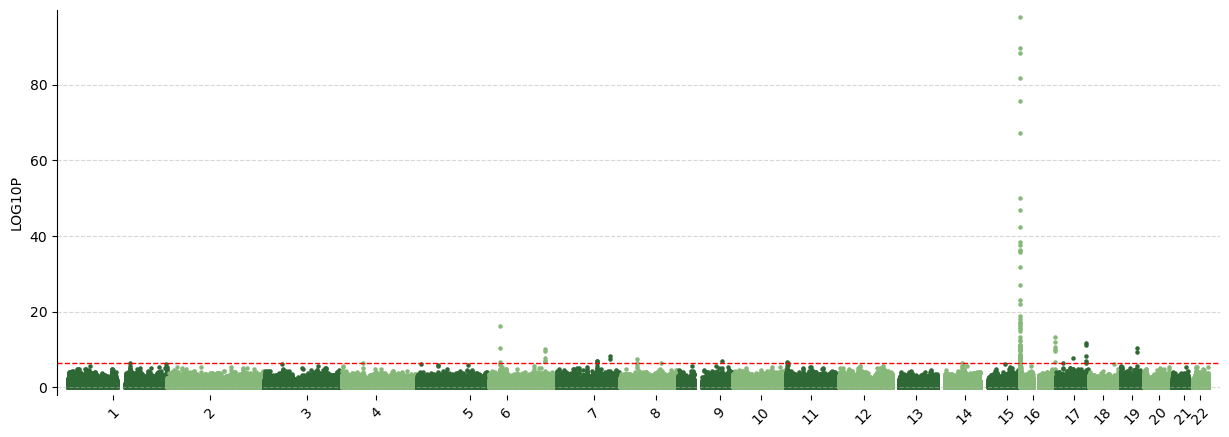

In [121]:
cell = 'K562'
foodie_bed = pr.read_bed('../FOODIE_20250407/FOODIE_merged_footprints/{}.merged.hg38.bed'.format(cell))
fig, ax1 = plt.subplots(nrows=1, figsize=(15, 5), sharex=True)
# Plot the common variant Manhattan plot on the left subplot
colors = ['#2e6834', '#86b979']
plot_manhattan(ax1, all_rare_K562, 'rare variants', sign='LOG10P', threshold=-np.log10(0.05/len(foodie_bed)), colors=colors)
plt.savefig('./K562_rare_erythroid_traits.png', dpi=400, transparent=True)

In [116]:
#  CRISPR dataset
CRISPR_data = pd.read_csv('../FOODIE_20250407/CRISPR_annot/EPCrisprBenchmark_ensemble_data_GRCh38_K562_foodie_annot.tsv', sep='\t')

In [117]:
CRISPR_data[CRISPR_data['measuredGeneSymbol'] == 'HBZ']

,chrom,chromStart,chromEnd,name,EffectSize,chrTSS,startTSS,endTSS,measuredGeneSymbol,Significant,...,ValidConnection,CellType,Reference,Regulated,Dataset,CRE_locus,chrom_foodie,start_footprint,end_footprint,footprint_id
499,chr16,142952,143452,HBZ|chr16:192951-193451:.,-0.351458,chr16,152687.0,152688.0,HBZ,True,...,True,K562,"Gasperini et al., 2019",True,Gasperini2019,"chr16:142952-143452|Gasperini et al., 2019",chr16,143129.0,143152.0,chr16:143129-143152
500,chr16,142952,143452,HBZ|chr16:192951-193451:.,-0.351458,chr16,152687.0,152688.0,HBZ,True,...,True,K562,"Gasperini et al., 2019",True,Gasperini2019,"chr16:142952-143452|Gasperini et al., 2019",chr16,143242.0,143258.0,chr16:143242-143258
501,chr16,144736,145236,HBZ|chr16:194735-195235:.,-0.221834,chr16,152687.0,152688.0,HBZ,True,...,True,K562,"Gasperini et al., 2019",True,Gasperini2019,"chr16:144736-145236|Gasperini et al., 2019",chr16,144989.0,145002.0,chr16:144989-145002
502,chr16,144736,145236,HBZ|chr16:194735-195235:.,-0.221834,chr16,152687.0,152688.0,HBZ,True,...,True,K562,"Gasperini et al., 2019",True,Gasperini2019,"chr16:144736-145236|Gasperini et al., 2019",chr16,145010.0,145040.0,chr16:145010-145040
503,chr16,144736,145236,HBZ|chr16:194735-195235:.,-0.221834,chr16,152687.0,152688.0,HBZ,True,...,True,K562,"Gasperini et al., 2019",True,Gasperini2019,"chr16:144736-145236|Gasperini et al., 2019",chr16,145127.0,145151.0,chr16:145127-145151


In [114]:
#  CRISPR dataset
CRISPR_data = pd.read_csv('../FOODIE_20250407/CRISPR_annot/EPCrisprBenchmark_ensemble_data_GRCh38.tsv.gz', sep='\t')

In [115]:
CRISPR_data[CRISPR_data['measuredGeneSymbol'] == 'HBZ']

,chrom,chromStart,chromEnd,name,EffectSize,chrTSS,startTSS,endTSS,measuredGeneSymbol,Significant,...,PowerAtEffectSize10,PowerAtEffectSize15,PowerAtEffectSize20,PowerAtEffectSize25,PowerAtEffectSize50,ValidConnection,CellType,Reference,Regulated,Dataset
3153,chr16,142952,143452,HBZ|chr16:192951-193451:.,-0.351458,chr16,152687.0,152688.0,HBZ,True,...,0.60,0.85,0.9,0.95,1.0,True,K562,"Gasperini et al., 2019",True,Gasperini2019
3154,chr16,144736,145236,HBZ|chr16:194735-195235:.,-0.221834,chr16,152687.0,152688.0,HBZ,True,...,0.45,0.75,0.8,0.90,1.0,True,K562,"Gasperini et al., 2019",True,Gasperini2019


In [118]:
K562_erythroid_rarevars_valid_dedup.merge(CRISPR_data[CRISPR_data['measuredGeneSymbol'] == 'HBZ'], left_on='Name_foodie', right_on='footprint_id')  # ['variant_id'].nunique(

,SNP,Name_foodie,chrom,chromStart,chromEnd,name,EffectSize,chrTSS,startTSS,endTSS,...,ValidConnection,CellType,Reference,Regulated,Dataset,CRE_locus,chrom_foodie,start_footprint,end_footprint,footprint_id
0,DRAGEN:chr16:145021:C:T,chr16:145010-145040,chr16,144736,145236,HBZ|chr16:194735-195235:.,-0.221834,chr16,152687.0,152688.0,...,True,K562,"Gasperini et al., 2019",True,Gasperini2019,"chr16:144736-145236|Gasperini et al., 2019",chr16,145010.0,145040.0,chr16:145010-145040


In [ ]:
# HBZ|chr16:194735-195235